In [ ]:
import os
os.environ['R_HOME'] = '/public/home/liuzj/softwares/anaconda3/envs/sc_py/lib/R'
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
from jpy_tools.rTools import py2r, r2py, r_inline_plot, rHelp, trl, rSet, rGet, ad2so, so2ad, so2md, rcontext, Trl, r2py_re, py2r_re
from jpy_tools import loadPkl, toPkl
rBase = importr('base')
rUtils = importr('utils')
dplyr = importr('dplyr')
reticulate = importr('reticulate')
R = ro.r
T = Trl()
R("options(browser='firefox', shiny.port=6533)")
%load_ext rpy2.ipython

2023-06-19 21:10:49.524263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

<Figure size 72x72 with 0 Axes>

In [ ]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
# plt.rcParams['figure.dpi'] = 150
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
sns.despine(top=True, right=True)
from itertools import product
from functools import reduce
import patchworklib as pw
from jpy_tools.otherTools import pwRecoverSeaborn, pwStack, F, pwShow
pw.show = pwShow
fc_recoverSns = pwRecoverSeaborn()
import seaborn.objects as so
from cycler import cycler
dt_snsStyle = {**sns.axes_style('ticks'), "legend.frameon": False, "axes.spines.top":False, "axes.spines.right":False, "axes.prop_cycle":cycler(color=['grey'])}

<Figure size 432x288 with 0 Axes>

In [ ]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import scipy.sparse as ss
from tqdm import tqdm
from jpy_tools.otherTools import F
from loguru import logger

In [ ]:
from jpy_tools import singleCellTools

Global seed set to 0
/public/home/liuzj/softwares/anaconda3/envs/sc_py/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/public/home/liuzj/softwares/anaconda3/envs/sc_py/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [ ]:
dir_10xh5 = "/public/home/liuzj/projects/singleCell/medicagoTruncatula/01_results/20210816/step1_cellRanger/"
dir_10xh5Medtr5 = "/public/home/liuzj/projects/singleCell/medicagoTruncatula/01_results/20220113/medtr5/results/step1_cellRanger"
dir_result = "/public/home/liuzj/projects/singleCell/medicagoTruncatula/01_results/20210816/step1_cellRanger/result_allData/"
path_gtf = (
    "/public/home/liuzj/data/medtrA17_4/Medicago_truncatula.MedtrA17_4.0.51.chr.gtf"
)

ls_name = ["control", "nf_0_5", "nf_6", "nf_24"]

In [ ]:
dir_temp = (
    "/data/Zhaijx/liuzj/projects/singleCell/02_jupyter/medicagoTruncatula/20220330/"
)

# load known SNF genes

In [ ]:
df_snfGenes = pd.read_excel(
    "/data/Zhaijx/liuzj/projects/singleCell/medicagoTruncatula/04_data/202120429 Reported nodule development related genes(1)(1)(1).xlsx",
)

In [ ]:
df_snfGenes = df_snfGenes.query("`Gene ` != 'SCR'")

In [ ]:
df_snfGenes["parsed_id"] = df_snfGenes.dropna(subset=["Gene ID V4"])[
    "Gene ID V4"
].str.replace("Medtr", "MTR_")

In [ ]:
ls_snfGenes = (
    df_snfGenes.query("parsed_id in @ad.var.index")["parsed_id"].unique().tolist()
)

In [ ]:
dt_locus2name = (
    df_snfGenes.dropna(subset=["parsed_id"])
    .drop_duplicates(["parsed_id"])
    .set_index("parsed_id")["Gene "]
    .to_dict()
)

In [ ]:
df_acronyms = pd.read_excel(
    "/data/Zhaijx/liuzj/data/medtrA17_4/geneInfo/Mt_gene_Acronyms_IDs_latest.xlsx",
    skiprows=2,
)

In [ ]:
dt_locus2name1 = (
    df_acronyms.dropna(subset=["Mt4.0 ID"])
    .set_index("Mt4.0 ID")
    .rename(lambda x: x.replace("Medtr", "MTR_"))["ACRONYM"]
    .to_dict()
)

In [ ]:
dt_locus2name1.update(dt_locus2name)

In [ ]:
dt_locus2name = dt_locus2name1

# load data

In [ ]:
ad_rep1 = loadPkl(
    "ad_20220815",
    lambda **dt: sc.read_h5ad(**dt),
    arg_path="filename",
    dir_path=dir_temp,
)

In [ ]:
ls_sample = ["control", "nf_0_5", "nf_6", "nf_24"]
ls_10xh5 = [f"{dir_10xh5}/{x}/{x}/outs/filtered_feature_bc_matrix.h5" for x in ls_sample]

In [ ]:
lsAd = [sc.read_10x_h5(x) for x in ls_10xh5]

for x in lsAd:
    x.var.index = x.var['gene_ids']

In [ ]:
ad = sc.concat(lsAd, label='batch_time', keys=ls_sample, index_unique='_batch_')

In [ ]:
sc.pp.filter_genes(ad, min_cells=1)

In [ ]:
singleCellTools.detectDoublet.byScDblFinder(ad, batch_key="batch_time")

2023-01-30 20:35:18.106 | INFO     | jpy_tools.singleCellTools.detectDoublet:byScDblFinder:169 - start to transfer adata to R
R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

2023-01-30 20:36:51.491 | INFO     | jpy_tools.singleCellTools.detectDoublet:byScDblFinder:175 - start to calculate doublet score
2023-01-30 20:43:28.259 | INFO     | jpy_tools.singleCellTools.detectDoublet:byScDblFinder:179 - start to intergrate result with adata
2023-01-30 20:43:29.217 | INFO     | jpy_tools.singleCellTools.detectDoublet:byScDblFinder:197 - before filter: 62865
2023-01-30 20:43:29.758 | INFO     | jpy_tools.singleCellTools.detectDoublet:byScDblFinder:201 - after filter: 55407


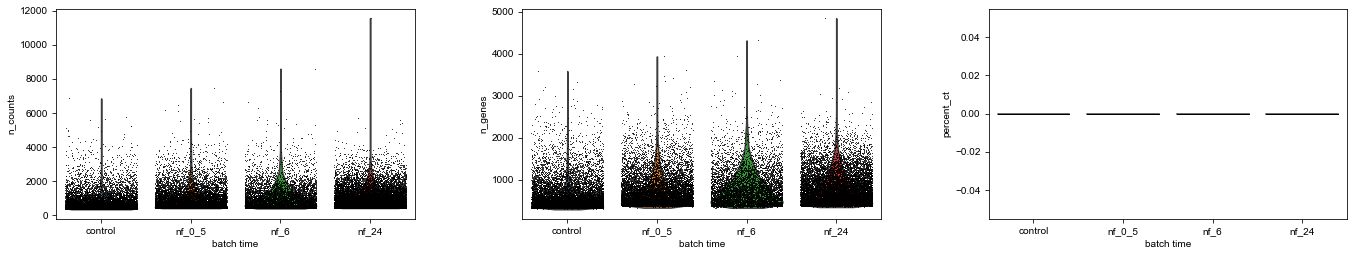

In [ ]:
singleCellTools.plotting.plotCellScatter(ad, batch='batch_time')

In [ ]:
ad_copy = ad.copy()

In [ ]:
ad = ad_copy[ad_copy.obs.eval("300<=n_genes<=3000 & 500<=n_counts<=5000")].copy()

In [ ]:
singleCellTools.basic.initLayer(ad)

In [ ]:
ls_sampleNew = ['0 hpi', '0.5 hpi', '6 hpi', '24 hpi']
dt_renameSample = dict(zip(ls_sample, ls_sampleNew))

In [ ]:
ad.obs = ad.obs.assign(
        Sample_4 = lambda df:df['batch_time'].map(dt_renameSample)
    ).assign(Sample_4 = lambda df:df['Sample_4'].astype('category').cat.set_categories(ls_sampleNew))

In [ ]:
ad_rep2 = ad.copy()

In [ ]:
# ad_rep2 = loadPkl('ad_0130_rep_after_qc', lambda **dt:sc.read_h5ad(**dt), arg_path='filename', dir_path=dir_result)

In [ ]:
ad = sc.concat([ad_rep1, ad_rep2], keys=['Batch 1', 'Batch 2'], label='Batch', index_unique='-')

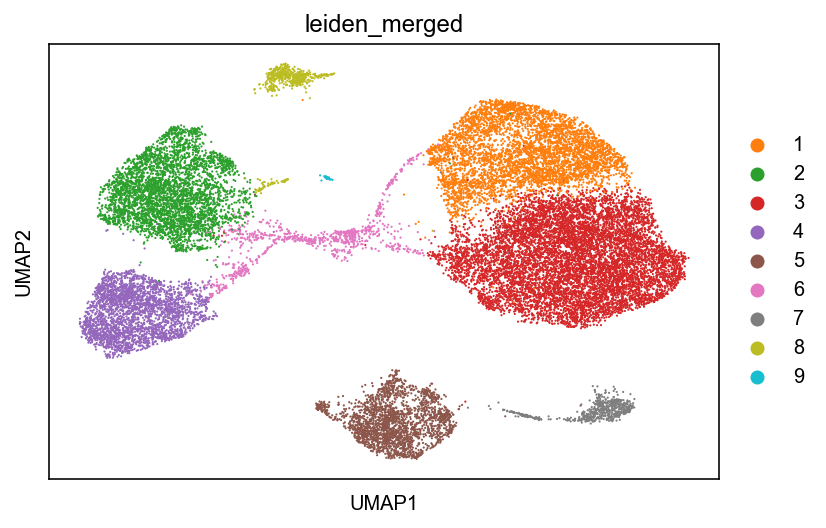

In [ ]:
sc.pl.umap(ad_rep1, color="leiden_merged")

In [ ]:
ad

AnnData object with n_obs × n_vars = 55683 × 32007
    obs: 'batch_time', 'n_counts', 'ct_merged', 'Sample_4', 'Batch'
    obsm: 'X_pca_normalizeLog', 'X_scvi', 'X_umap', 'scDblFinder'
    layers: 'normalize_log', 'raw'

In [ ]:
toPkl(ad, "ad", "scem")

2023-06-19 19:50:35.848 | INFO     | jpy_tools.otherTools:toPkl:476 - please run `loadPkl('ad', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


0


In [ ]:
# ad.obs['Batch_Sample'] = ad.obs['Batch'].astype(str) + ad.obs['Sample_4'].astype(str)
# sc.pp.highly_variable_genes(ad, layer='raw', batch_key='Batch_Sample', n_top_genes=5000, flavor='seurat_v3')
# scvi.model.SCVI.setup_anndata(ad, layer='raw', batch_key='Batch_Sample', categorical_covariate_keys=['Batch', 'Sample_4'])
# scvi.settings.seed = 39
# scvi.settings.num_threads = 56
# model = scvi.model.SCVI(ad)
# model.train()
# ad.obsm['X_scvi'] = model.get_latent_representation(ad).copy()
# sc.pp.neighbors(ad, use_rep='X_scvi')
# sc.tl.umap(ad)

In [ ]:
ad = loadPkl("ad", lambda **dt: sc.read_h5ad(**dt), arg_path="filename")

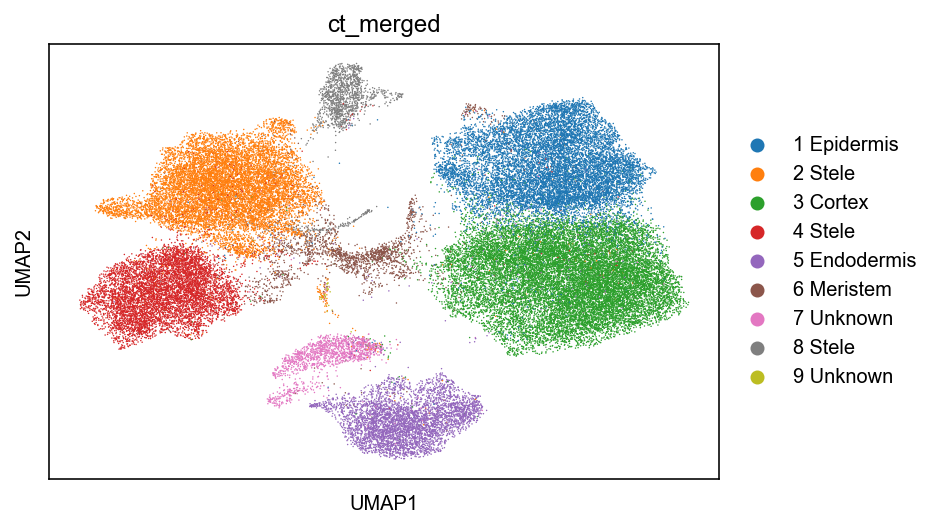

In [ ]:
sc.pl.umap(ad, color="ct_merged")

In [ ]:
sc.tl.leiden(ad, resolution=0.4)

In [ ]:
ad.obs["leiden"] = ad.obs["leiden"].map(
    lambda x: x >> F(int) >> F(lambda x: x + 1) >> F(str)
)
_dt = {
    "1": "3",
    "2": "1",
    "3": "2",
    "9": "9",
}
ad.obs["leiden"] = ad.obs["leiden"].map(lambda x: _dt.get(x, x))


In [ ]:
ad.obs["leiden"] = ad.obs["leiden"].astype(str)

In [ ]:
ad.uns["leiden_colors"] = ad_rep1.uns["leiden_merged_colors"]

... storing 'leiden' as categorical


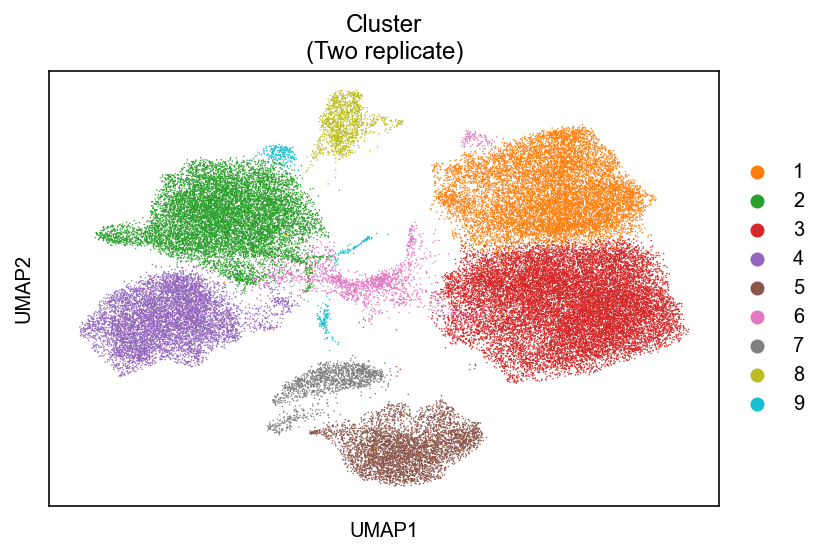

In [ ]:
sc.pl.umap(ad, color="leiden", title="Cluster\n(Two replicate)")

In [ ]:
ad.obs = ad.obs.assign(Rep=lambda x: x["Batch"].str.replace("Batch", "Replicate"))

... storing 'Rep' as categorical


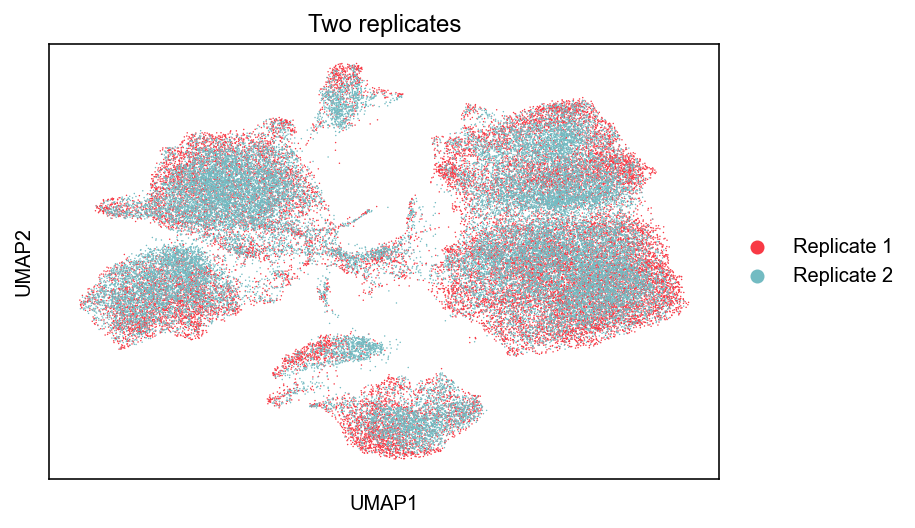

In [ ]:
sc.pl.umap(ad, color="Rep", title="Two replicates", palette=["#F83945", "#73BBC2"])

In [ ]:
singleCellTools.geneEnrichInfo.calculateEnrichScoreByCellex(
    ad, "raw", clusterName="leiden"
)

In [ ]:
toPkl(ad, "ad_two_rep_integrated_scvi_0620", "ipf")

2023-06-20 16:33:39.133 | INFO     | jpy_tools.otherTools:toPkl:476 - please run `loadPkl('ad_two_rep_integrated_scvi_0620', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


In [ ]:
import importlib

In [ ]:
import pysankey

# importlib.reload(pysankey)
# importlib.reload(pysankey.sankey)

In [ ]:
ad_rep1 = loadPkl(
    "ad_20220815",
    lambda **dt: sc.read_h5ad(**dt),
    arg_path="filename",
    dir_path=dir_temp,
)


In [ ]:
ad_rep1.obs = ad_rep1.obs.assign(
    leiden_two_reps=lambda x: ad[x.index + "-Batch 1"].obs["leiden"].values
)

2023-06-20 15:42:12 - WARNING -  The following arguments are deprecated and should be removed: figSize in sankey()


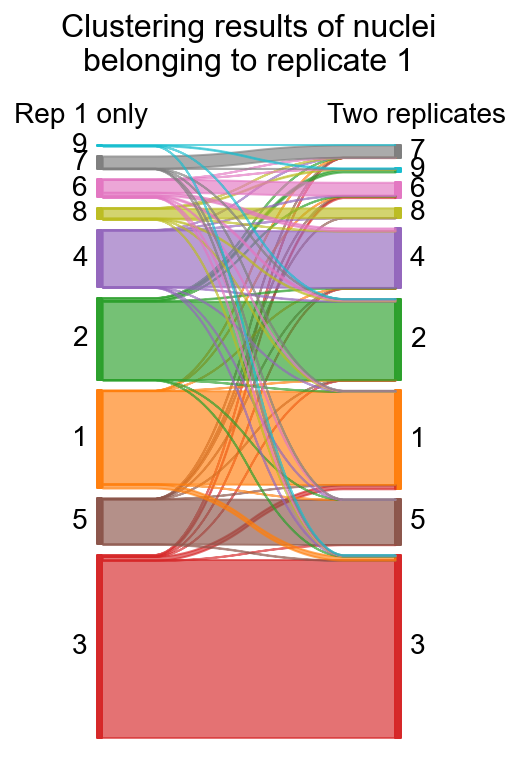

In [ ]:
with plt.rc_context({"font.family": "Arial"}):
    ax = pysankey.sankey(
        ad_rep1.obs["leiden_merged"],
        ad_rep1.obs["leiden_two_reps"],
        figSize=(3, 6),
        colorDict=singleCellTools.basic.getadataColor(ad_rep1, "leiden_merged"),
    )
    ax.text(
        1,
        0.98,
        "Two replicates",
        ha="center",
        va="bottom",
        fontsize=14,
        transform=ax.transAxes,
    )

    ax.text(
        0,
        0.98,
        "Rep 1 only",
        ha="center",
        va="bottom",
        fontsize=14,
        transform=ax.transAxes,
    )
    ax.set_title(
        "Clustering results of nuclei\nbelonging to replicate 1", y=1.05, fontsize=16
    )

## plot marker

In [ ]:
_dt = {
    "1": [
        "MTR_5g083030",
        "MTR_4g083570",
        "MTR_6g027840",
        "MTR_4g116990",
        "MTR_5g019040",
        "MTR_1g090807",
        "MTR_5g099060",
    ],
    "2": [
        "MTR_4g008860",
        "MTR_6g069510",
        "MTR_7g067450",
        "MTR_6g084640",
        "MTR_4g060460",
        "MTR_3g094120",
        "MTR_3g462710",
        "MTR_2g093740",
    ],
    "3": ["MTR_4g088170", "MTR_1g074930", "MTR_4g088195", "MTR_5g097910"],
    "4": ["MTR_6g023805", "MTR_3g029510", "MTR_3g102600", "MTR_7g085180"],
    "5": ["MTR_4g088055", "MTR_8g038210", "MTR_1g094810", "MTR_3g078260"],
    "6": [
        "MTR_2g098180",
        "MTR_4g127100",
        "MTR_4g065370",
        "MTR_7g080460",
        "MTR_6g087980",
        "MTR_6g086170",
        "MTR_3g107970",
        "MTR_3g069590",
        "MTR_2g090875",
    ],
    "7": [],
    "8": ["MTR_4g070970", "MTR_3g079850", "MTR_1g072540", "MTR_5g025730"],
    "9": ["MTR_4g132350"],
}

... storing 'subcluster_of_1' as categorical


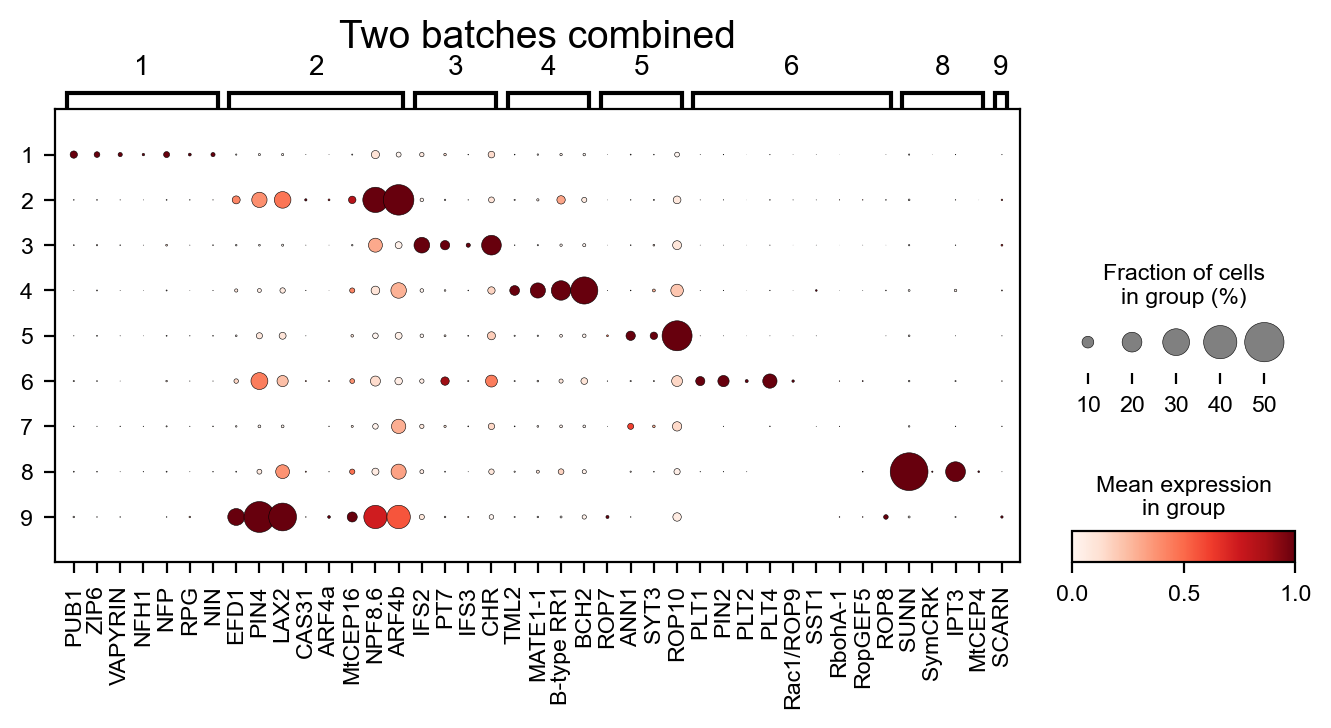

In [ ]:
with plt.rc_context({"figure.dpi": 100}):
    axs = sc.pl.dotplot(
        ad,
        {x: y for x, y in _dt.items() if y},
        "leiden",
        layer="normalize_log",
        cmap="Reds",
        standard_scale="var",
        figsize=(8, 3),
        show=False,
    )
    plt.sca(axs["mainplot_ax"])
    ls_originXLabel = (
        axs["mainplot_ax"].get_xticklabels() | F(map, lambda x: x.get_text()) | F(list)
    )
    plt.xticks(
        range(len(ls_originXLabel)) | F(map, lambda x: x + 0.5) | F(list),
        ls_originXLabel | F(map, lambda x: dt_locus2name[x]),
    )

    # axs['size_legend_ax'].set_position([0.25, -0.2, 0.15, 0.1])
    # axs['color_legend_ax'].set_position([0.45, -0.2, 0.15, 0.05])
    plt.title("Two batches combined", y=1.1, fontsize=14)
    plt.show()

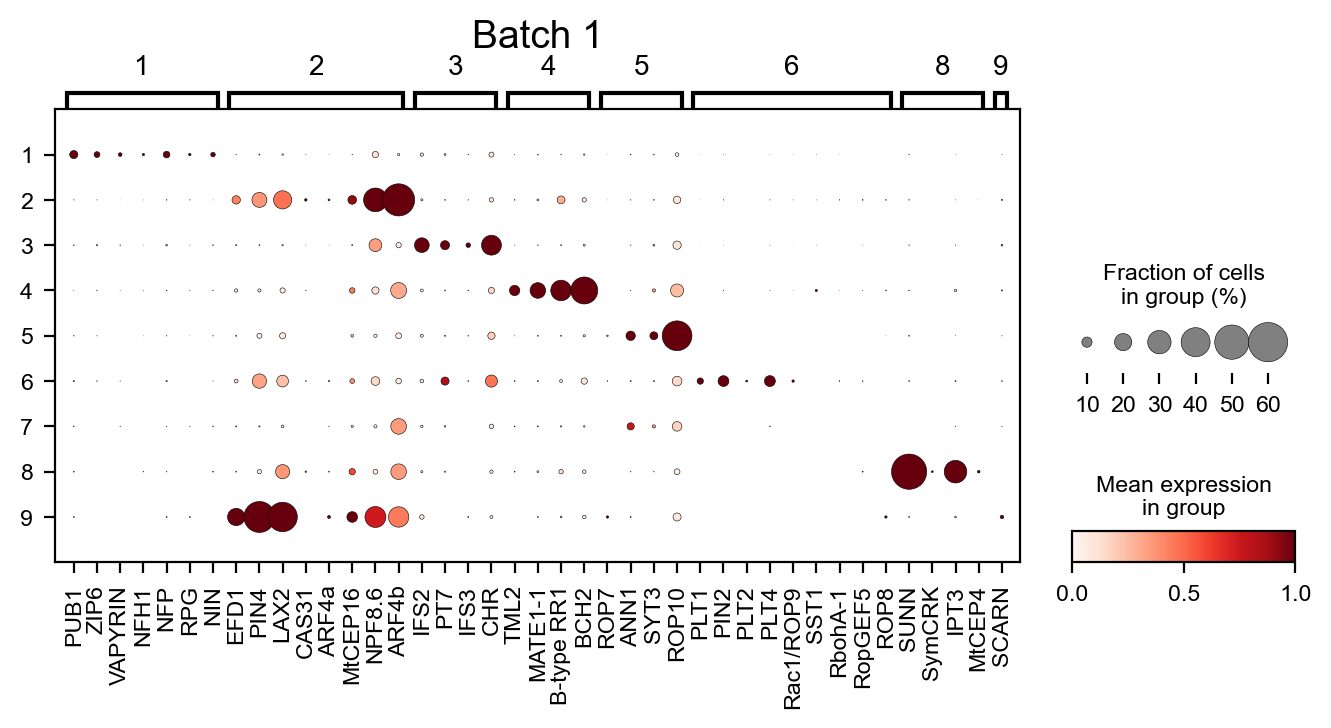

In [ ]:
with plt.rc_context({"figure.dpi": 100}):
    axs = sc.pl.dotplot(
        ad[ad.obs.eval("Batch == 'Batch 1'")],
        {x: y for x, y in _dt.items() if y},
        "leiden",
        layer="normalize_log",
        cmap="Reds",
        standard_scale="var",
        figsize=(8, 3),
        show=False,
    )
    plt.sca(axs["mainplot_ax"])
    ls_originXLabel = (
        axs["mainplot_ax"].get_xticklabels() | F(map, lambda x: x.get_text()) | F(list)
    )
    plt.xticks(
        range(len(ls_originXLabel)) | F(map, lambda x: x + 0.5) | F(list),
        ls_originXLabel | F(map, lambda x: dt_locus2name[x]),
    )

    # axs['size_legend_ax'].set_position([0.25, -0.2, 0.15, 0.1])
    # axs['color_legend_ax'].set_position([0.45, -0.2, 0.15, 0.05])
    plt.title("Batch 1", y=1.1, fontsize=14)
    plt.show()

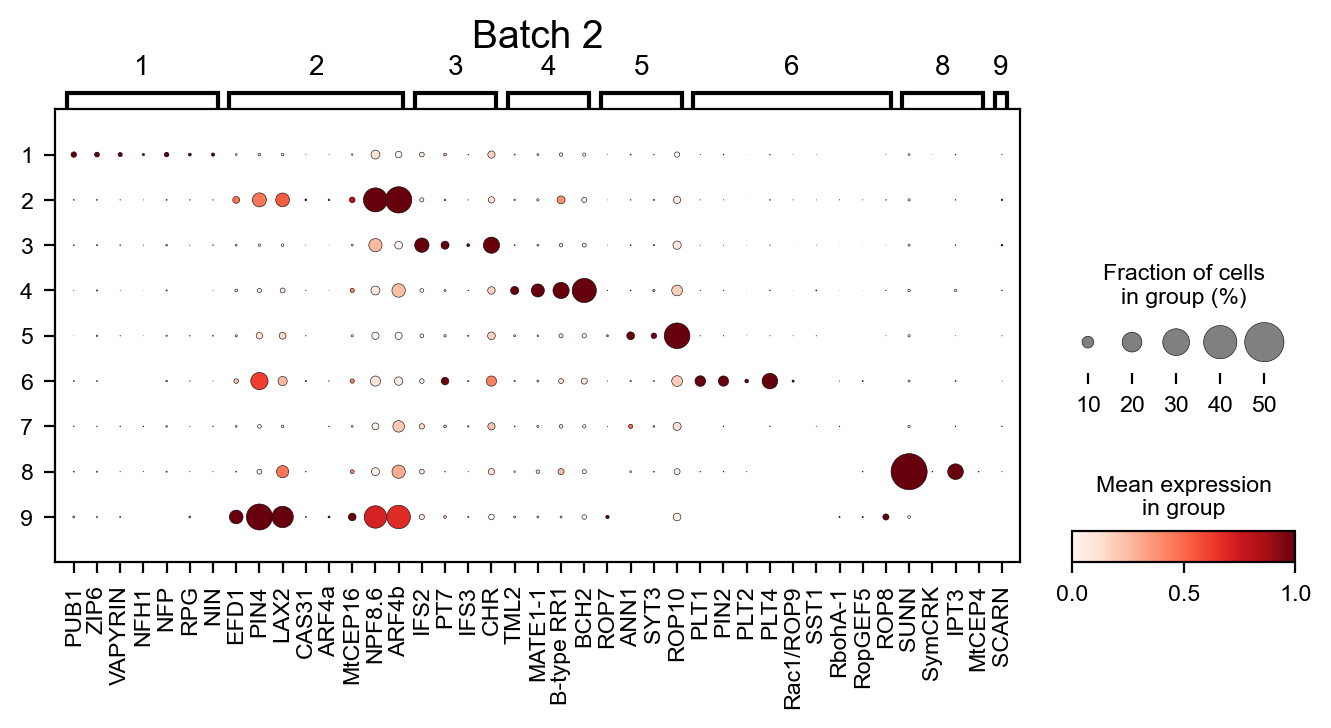

In [ ]:
with plt.rc_context({"figure.dpi": 100}):
    axs = sc.pl.dotplot(
        ad[ad.obs.eval("Batch == 'Batch 2'")],
        {x: y for x, y in _dt.items() if y},
        "leiden",
        layer="normalize_log",
        cmap="Reds",
        standard_scale="var",
        figsize=(8, 3),
        show=False,
        dot_max=0.5,
    )
    plt.sca(axs["mainplot_ax"])
    ls_originXLabel = (
        axs["mainplot_ax"].get_xticklabels() | F(map, lambda x: x.get_text()) | F(list)
    )
    plt.xticks(
        range(len(ls_originXLabel)) | F(map, lambda x: x + 0.5) | F(list),
        ls_originXLabel | F(map, lambda x: dt_locus2name[x]),
    )

    # axs['size_legend_ax'].set_position([0.25, -0.2, 0.15, 0.1])
    # axs['color_legend_ax'].set_position([0.45, -0.2, 0.15, 0.05])
    plt.title("Batch 2", y=1.1, fontsize=14)

    plt.show()

## edgeR

In [ ]:
edgeR = importr("edgeR")
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
ad_pseudoBulk = singleCellTools.geneEnrichInfo._mergeData(
    ad, ["Sample_4", "Batch", "leiden"]
)

In [ ]:
singleCellTools.basic.initLayer(ad_pseudoBulk, total=1e6)

In [ ]:
funcR_callEdgeRContrast = R(
    """
\(dfR_exp,vtR_group, contrast) {
    y <- DGEList(counts=dfR_exp,group=vtR_group)
    keep <- filterByExpr(y)
    y <- y[keep,,keep.lib.sizes=FALSE]
    y <- calcNormFactors(y)
    design <- model.matrix(~0+vtR_group)
    contrast <- do.call(makeContrasts, list(contrast, levels=design))
    y <- estimateDisp(y,design)
    fit <- glmFit(y,design,)
    lrt <- glmLRT(fit, contrast=contrast)
    lrt <- as.data.frame(lrt)
    return(lrt)
}
"""
)

In [ ]:
dt_contrast = {
    "0 hpi": "vtR_groupa-(vtR_groupb+vtR_groupc+vtR_groupd)/3",
    "0.5 hpi": "vtR_groupb-(vtR_groupa+vtR_groupc+vtR_groupd)/3",
    "6 hpi": "vtR_groupc-(vtR_groupa+vtR_groupb+vtR_groupd)/3",
    "24 hpi": "vtR_groupd-(vtR_groupa+vtR_groupb+vtR_groupc)/3",
}  # based on edgeR 's author's suggestion (https://support.bioconductor.org/p/9139971/)

In [ ]:
lsDf = []
for cellType, _ad in singleCellTools.basic.splitAdata(
    ad_pseudoBulk, "leiden", needName=True
):
    if cellType == "9":
        continue
    for sample in ["0 hpi", "0.5 hpi", "6 hpi", "24 hpi"]:
        # _ad_forEdgeR = singleCellTools.geneEnrichInfo._mergeData(_ad, ['Batch','Sample_4'])
        _ad_forEdgeR = _ad.copy()
        _ad_forEdgeR.obs["edgeR_temp"] = _ad_forEdgeR.obs["Sample_4"].map(
            dict(zip(["0 hpi", "0.5 hpi", "6 hpi", "24 hpi"], ["a", "b", "c", "d"]))
        )
        _ad_forEdgeR.obs["edgeR_temp"] = (
            _ad_forEdgeR.obs["edgeR_temp"]
            .astype("category")
            .cat.set_categories(["a", "b", "c", "d"])
        )
        # _ad_forEdgeR.obs = _ad_forEdgeR.obs.assign(
        #             edgeR_temp=lambda df: np.where(df["Sample_4"] == sample, '1', '0')
        #         ).assign(
        #             edgeR_temp=lambda df: df["edgeR_temp"]
        #             .astype("category")
        #             .cat.set_categories(['0', '1'])
        # )
        dfR_exp = py2r(_ad_forEdgeR.to_df("raw").T)
        vtR_group = py2r(_ad_forEdgeR.obs["edgeR_temp"])
        df_lrt = funcR_callEdgeRContrast(dfR_exp, vtR_group, dt_contrast[sample]) >> F(
            r2py
        )
        df_lrt["fdr"] = fdrcorrection(df_lrt["PValue"])[1]
        df_lrt["cellType"] = cellType
        df_lrt["sample"] = sample
        lsDf.append(df_lrt)

100%|██████████| 9/9 [04:04<00:00, 27.12s/it]


In [ ]:
df_edgeRContrast = pd.concat(lsDf)

In [ ]:
ad.uns["edgeR"] = df_edgeRContrast

In [ ]:
# toPkl(ad, "ad_after_edgeR", "ipf")

2023-06-21 14:23:18.760 | INFO     | jpy_tools.otherTools:toPkl:476 - please run `loadPkl('ad_after_edgeR', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


In [ ]:
df_edgeRContrastCopy = df_edgeRContrast.copy()

In [ ]:
df_edgeRContrast["cellType"] = df_edgeRContrast["cellType"].astype("category")

In [ ]:
df_edgeRContrast = df_edgeRContrast.query("fdr < 0.05 & logFC > 1")

In [ ]:
# df_edgeRContrast.rename(index=lambda x: x.replace("MTR_", "Medtr")).to_excel(
#     f"{dir_result}/rep_inte_0629_timeGene.xlsx"
# )

In [ ]:
df_edgeRContrast["sample"] = (
    df_edgeRContrast["sample"]
    .astype("category")
    .cat.set_categories(["0 hpi", "0.5 hpi", "6 hpi", "24 hpi"])
)

In [ ]:
# df_edgeRContrast['gene'] = df_edgeRContrast.index

In [ ]:
df_responseGeneCounts = (
    df_edgeRContrast.value_counts(["cellType", "sample"]).rename("counts").reset_index()
)

In [ ]:
df_responseGeneCounts["sample"] = (
    df_responseGeneCounts["sample"]
    .astype("category")
    .cat.set_categories(["0 hpi", "0.5 hpi", "6 hpi", "24 hpi"])
)

In [ ]:
df_responseGeneCounts["sample"] = df_responseGeneCounts["sample"].map(
    lambda x: "Control" if x == "0 hpi" else x
)

In [ ]:
df_responseGeneCounts = df_responseGeneCounts.assign(
    sample=lambda x: x["sample"]
    .str.replace("hpi", "hpt")
    .astype("category")
    .cat.set_categories(["Control", "0.5 hpt", "6 hpt", "24 hpt"])
)

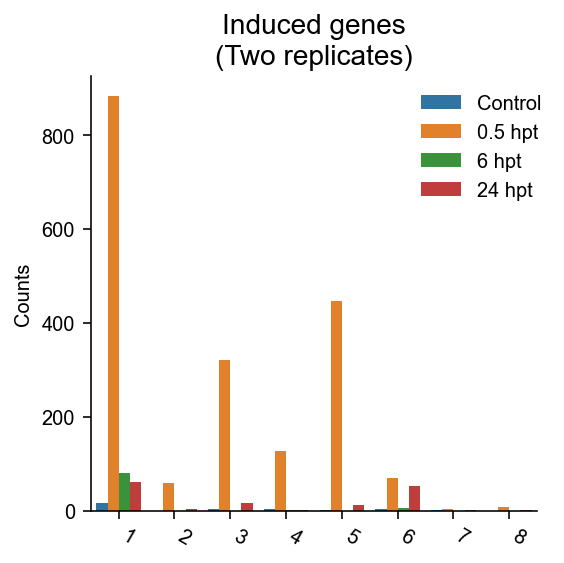

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(data=df_responseGeneCounts, x="cellType", y="counts", hue="sample")
plt.legend(loc="upper left", bbox_to_anchor=(0.7, 1), frameon=False)
plt.xticks(rotation=-30, ha="left")
plt.xlabel("")
plt.ylabel("Counts")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Induced genes\n(Two replicates)", fontsize=14)
plt.show()

In [ ]:
1

## overlap

In [ ]:
# ad_rep1 = loadPkl('ad_20220815', lambda **dt:sc.read_h5ad(**dt), arg_path='filename', dir_path=dir_temp)

In [ ]:
df_diffxpyResultRep1 = ad_rep1.uns["diffxpy_clusterResponse"]
df_diffxpyResultRep1 = df_diffxpyResultRep1.query(
    "qval < 0.05 & log2fc > 1"
)  # ratio> 0.1

In [ ]:
_dt = {"Mock": "0 hpi"}
ls_sample = ["0 hpi", "0.5 hpi", "6 hpi", "24 hpi"]
df_diffxpyResultRep1 = df_diffxpyResultRep1.assign(
    Sample_4=lambda df: df["sample"]
    .map(lambda x: _dt.get(x, x))
    .astype("category")
    .cat.set_categories(ls_sample),
    cluster=lambda df: df["cluster"].astype("category"),
)

In [ ]:
import matplotlib_venn
from itertools import product

In [ ]:
ls_cluster = [
    "1 Epidermis",
    "2 Stele",
    "3 Cortex",
    "4 Stele",
    "5 Endodermis",
    "6 Meristem",
    "7 Unknown",
    "8 Stele",
]

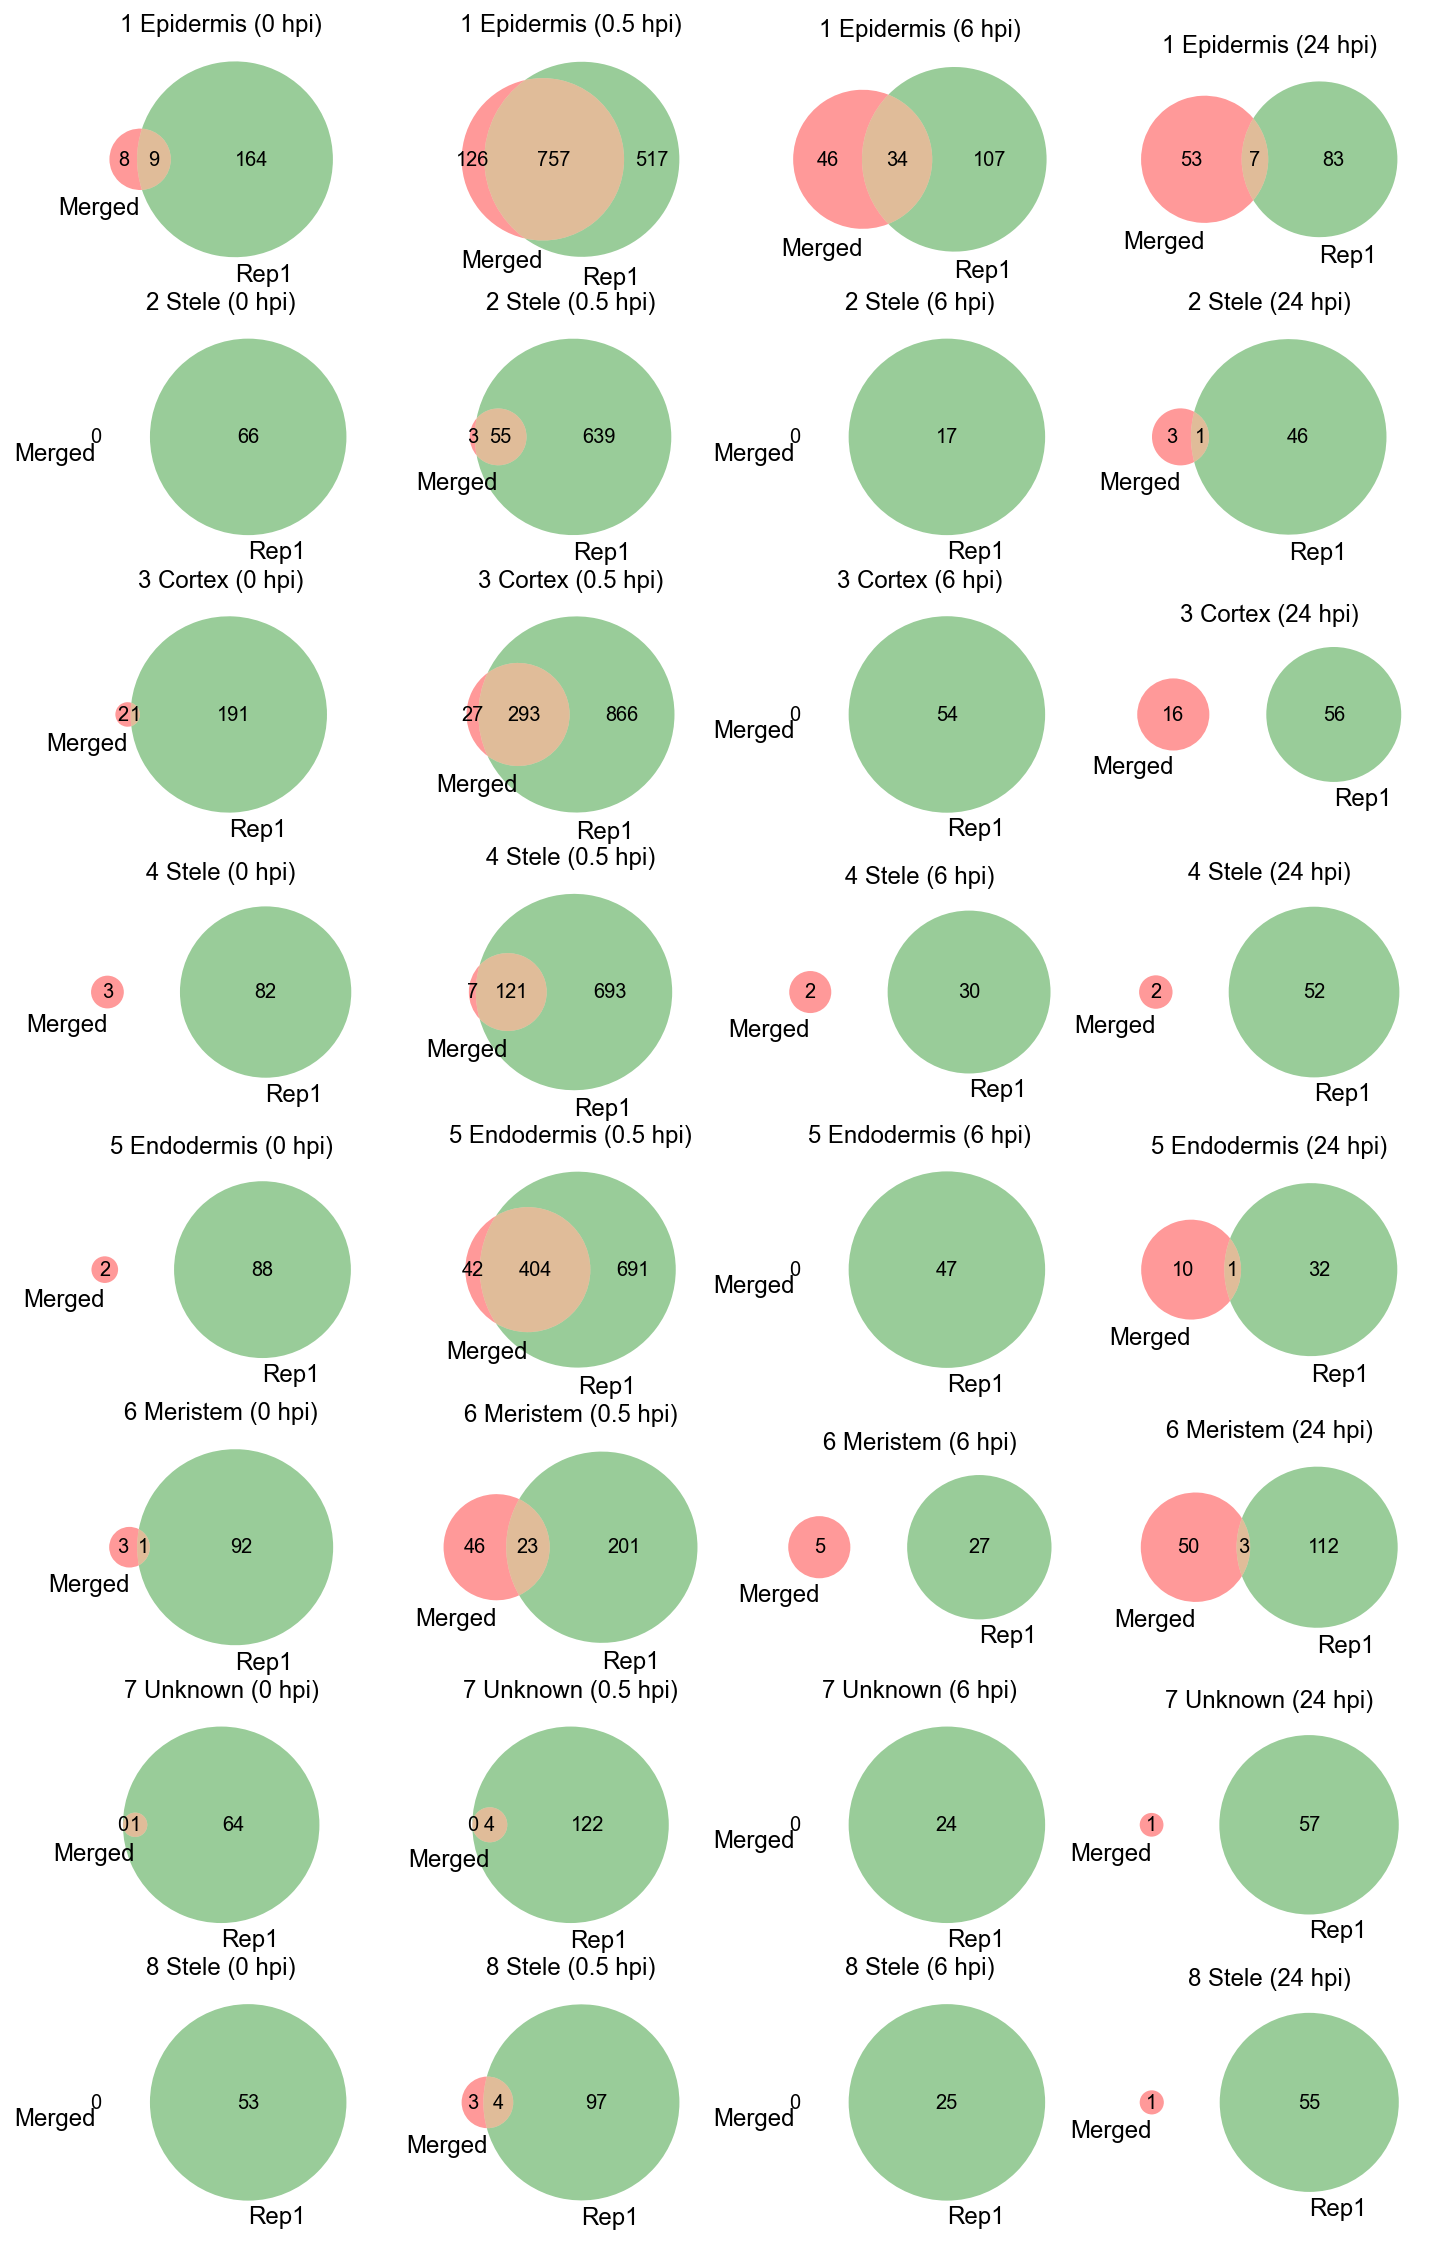

In [ ]:
fig, axs = plt.subplots(len(ls_cluster), len(ls_sample), figsize=(12, 20))
axs = axs.flatten()
for (cluster, sample), ax in zip(product(ls_cluster, ls_sample), axs):
    df = df_edgeRContrast.query("cellType == @cluster[0] & sample == @sample")
    dfRep1 = df_diffxpyResultRep1.query("cluster == @cluster & Sample_4 == @sample")
    # print(cluster, sample)
    matplotlib_venn.venn2(
        [set(df.index), set(dfRep1.gene)], set_labels=["Merged", "Rep1"], ax=ax
    )
    plt.sca(ax)
    plt.title(f"{cluster} ({sample})")
plt.show()
# break

In [ ]:
ls_cluster = [
    "1 Epidermis",
    "2 Stele",
    "3 Cortex",
    "4 Stele",
    "5 Endodermis",
    "6 Meristem",
    "7 Unknown",
    "8 Stele",
]

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

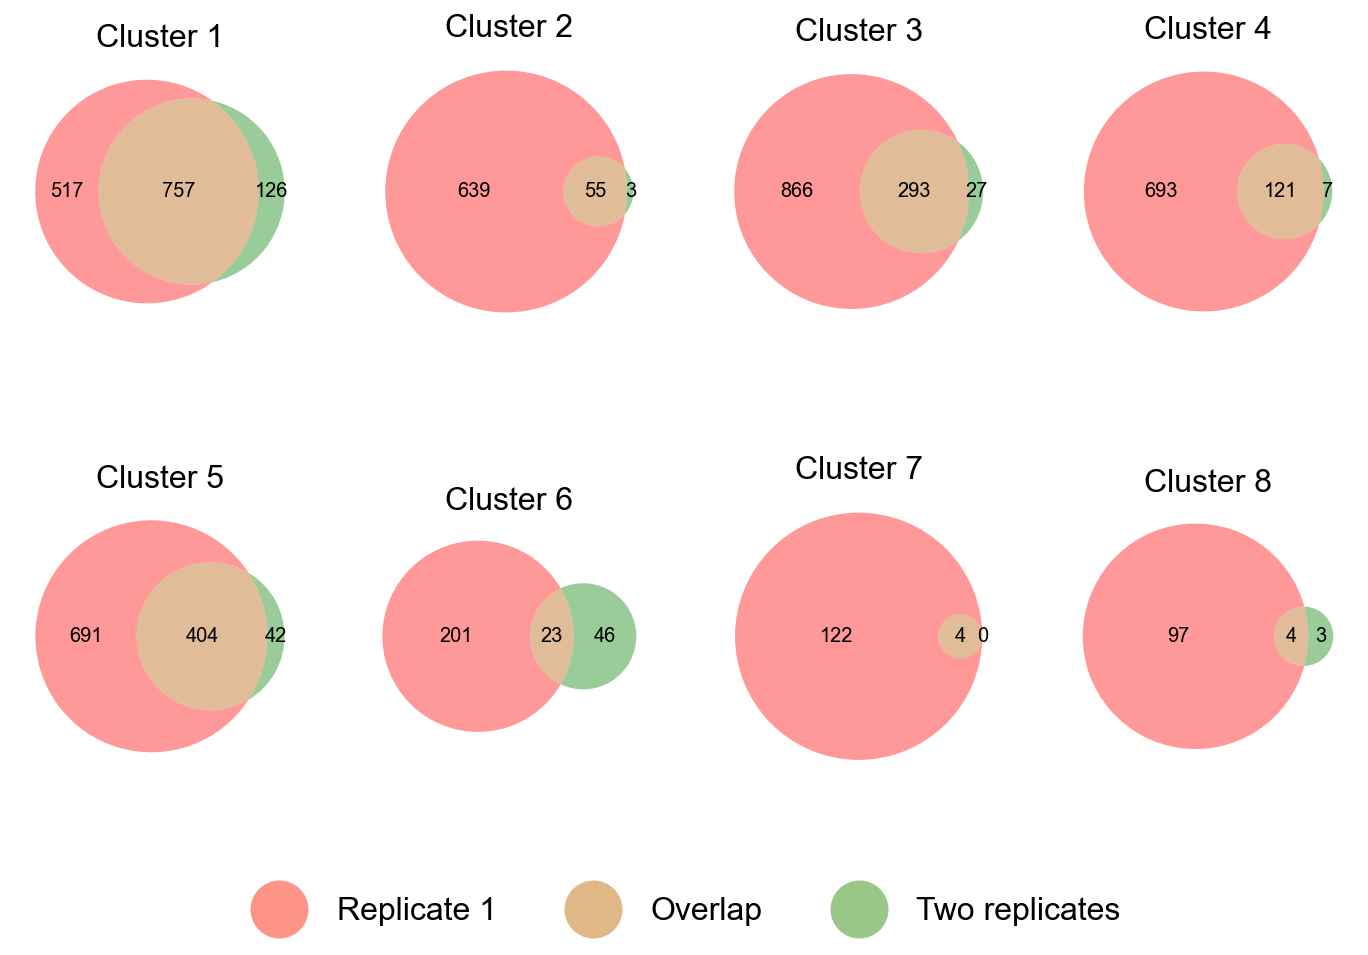

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 7.5))
axs = axs.flatten()
sample = "0.5 hpi"
for cluster, ax in zip(ls_cluster, axs):
    df = df_edgeRContrast.query("cellType == @cluster[0] & sample == @sample")
    dfRep1 = df_diffxpyResultRep1.query("cluster == @cluster & Sample_4 == @sample")
    matplotlib_venn.venn2(
        [set(dfRep1.gene), set(df.index)],
        set_labels=["Replicate 1", "Two replicates"],
        ax=ax,
    )
    plt.sca(ax)
    plt.title(f"Cluster {cluster[0]}", fontsize=16)
# plt.()
for ax in fig.axes:
    ax.texts.pop(3)
    ax.texts.pop(3)

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Replicate 1",
        markerfacecolor="#FE9488",
        markersize=30,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Overlap",
        markerfacecolor="#E0B888",
        markersize=30,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Two replicates",
        markerfacecolor="#98C788",
        markersize=30,
    ),
]

fig.legend(
    handles=legend_elements, ncol=3, loc="lower center", frameon=False, fontsize=16
)

plt.show()

## spatialtemporal gene

In [ ]:
# toPkl(ad, "ad_20230629_two_rep_integrate", "ipf", dir_path=dir_result)

2023-06-29 11:50:30.623 | INFO     | jpy_tools.otherTools:toPkl:476 - please run `loadPkl('ad_20230629_two_rep_integrate', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


In [ ]:
df_illuMarker = ad.uns["leiden_cellexES"].query("enrichScore > 0.8")

In [ ]:
dt_specficGenes = df_illuMarker.groupby("leiden")["gene"].agg(list).to_dict()

In [ ]:
def _filter(sr):
    ls_genes = dt_specficGenes[sr.loc["cellType"]]
    if sr.loc["gene"] in ls_genes:
        return True
    else:
        return False

In [ ]:
df_edgerSpec = df_edgeRContrast.assign(gene=lambda x: x.index).loc[
    lambda df: df.apply(_filter, axis=1)
]

In [ ]:
df_responseGeneCounts = (
    df_edgerSpec.value_counts(["cellType", "sample"]).rename("counts").reset_index()
)

In [ ]:
df_responseGeneCounts

cellType   sample  counts
0         1  0.5 hpi      78
1         5  0.5 hpi      24
2         3  0.5 hpi      22
3         1    6 hpi      21
4         1   24 hpi       6
5         4  0.5 hpi       6
6         1    0 hpi       2
7         6  0.5 hpi       2
8         6   24 hpi       2
9         2  0.5 hpi       1
10        3   24 hpi       1
11        6    6 hpi       1

In [ ]:
# df_responseGeneCounts["sample"] = (
#     df_responseGeneCounts["sample"]
#     .astype("category")
#     .cat.set_categories(["0 hpi", "0.5 hpi", "6 hpi", "24 hpi"])
#     .str.replace("hpi", "hpt")
# )

In [ ]:
df_responseGeneCounts["cellType"] = (
    df_responseGeneCounts["cellType"]
    .astype("category")
    .cat.set_categories(range(1, 9) >> F(map, str) >> F(list))
)
df_responseGeneCounts["sample"] = df_responseGeneCounts["sample"].map(
    lambda x: "Control" if x == "0 hpi" else x
)

In [ ]:
df_responseGeneCounts = df_responseGeneCounts.assign(
    sample=lambda x: x["sample"]
    .str.replace("hpi", "hpt")
    .astype("category")
    .cat.set_categories(["Control", "0.5 hpt", "6 hpt", "24 hpt"])
)

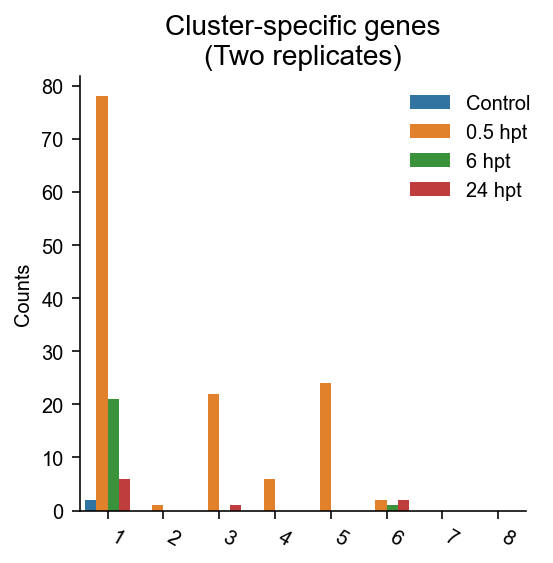

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(data=df_responseGeneCounts, x="cellType", y="counts", hue="sample")
plt.legend(loc="upper left", bbox_to_anchor=(0.7, 1), frameon=False)
plt.xticks(rotation=-30, ha="left")
plt.xlabel("")
plt.ylabel("Counts")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Cluster-specific genes\n(Two replicates)", fontsize=14)

plt.show()

## subcluster of 1

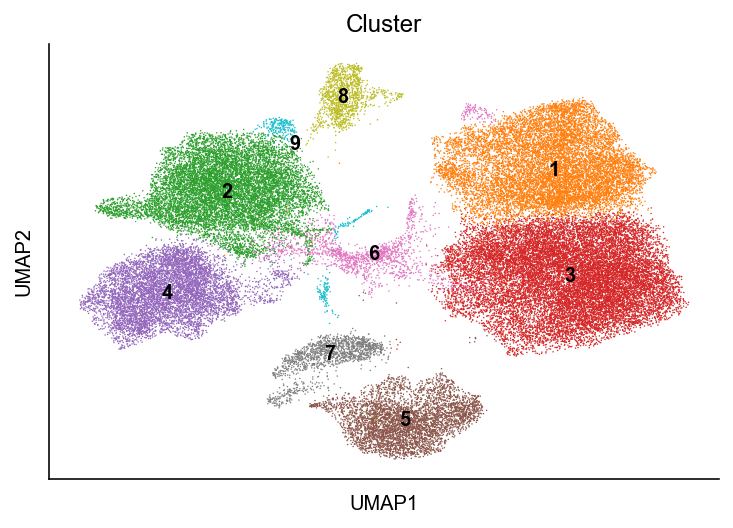

In [ ]:
sc.pl.umap(ad, color="leiden", legend_loc="on data", show=False)
sns.despine()
plt.title("Cluster")
plt.show()

In [ ]:
ad_epi = ad[ad.obs.eval("leiden == '1'")]

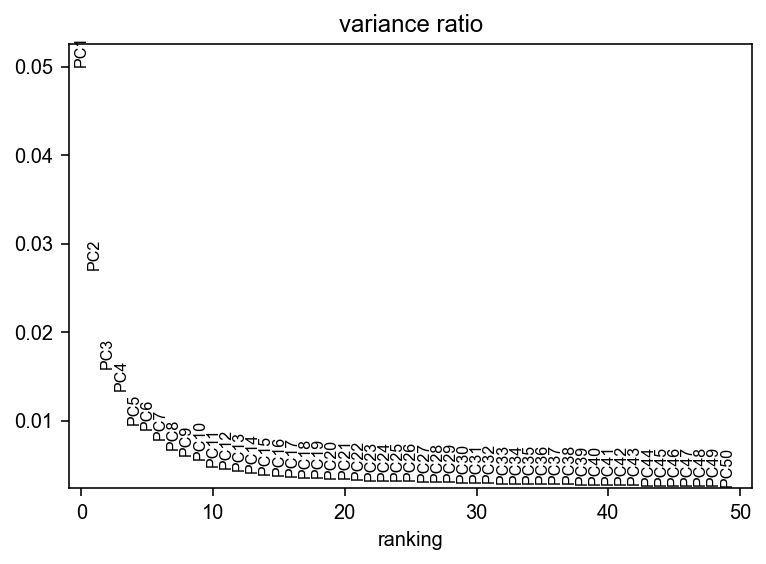

In [ ]:
ad_epi.X = ad_epi.layers["raw"].copy()
sc.pp.filter_genes(ad_epi, min_cells=10)
sc.pp.highly_variable_genes(
    ad_epi, layer="raw", n_top_genes=3000, flavor="seurat_v3", batch_key="Batch_Sample"
)
ad_epi.X = ad_epi.layers["normalize_log"].copy()
sc.tl.pca(ad_epi)
sc.pl.pca_variance_ratio(ad_epi, 50)

In [ ]:
import scanpy.external as sce

In [ ]:
ad_epi.obsm["X_pca_10"] = ad_epi.obsm["X_pca"][:, :30]
sce.pp.harmony_integrate(ad_epi, key="Batch_Sample", basis="X_pca_10")
sc.pp.neighbors(ad_epi, use_rep="X_pca_harmony")
sc.tl.umap(ad_epi, 0.1)

2023-06-20 15:16:46,602 - harmonypy - INFO - Iteration 1 of 10
2023-06-20 15:16:46 - INFO - Iteration 1 of 10
2023-06-20 15:16:50,260 - harmonypy - INFO - Iteration 2 of 10
2023-06-20 15:16:50 - INFO - Iteration 2 of 10
2023-06-20 15:16:53,959 - harmonypy - INFO - Iteration 3 of 10
2023-06-20 15:16:53 - INFO - Iteration 3 of 10
2023-06-20 15:16:57,626 - harmonypy - INFO - Iteration 4 of 10
2023-06-20 15:16:57 - INFO - Iteration 4 of 10
2023-06-20 15:17:01,354 - harmonypy - INFO - Converged after 4 iterations
2023-06-20 15:17:01 - INFO - Converged after 4 iterations


In [ ]:
sc.tl.leiden(ad_epi, resolution=0.15)

In [ ]:
ad_epi.uns["Batch_colors"] = ["#F8444F", "#78BDC4"]

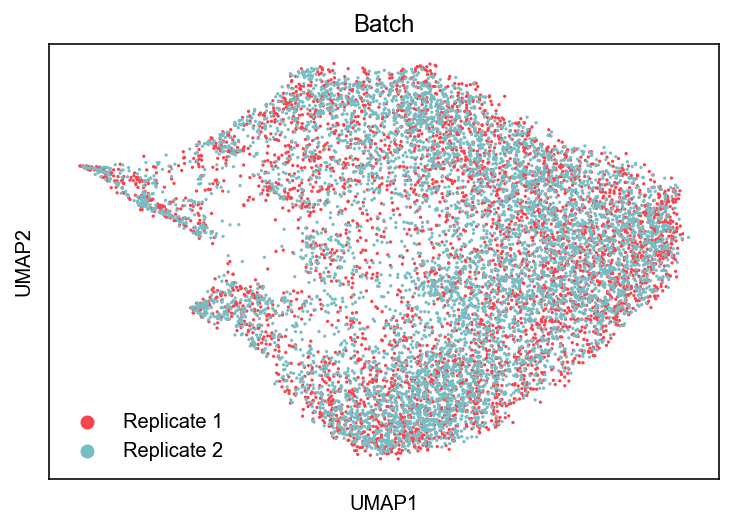

In [ ]:
ax = sc.pl.umap(ad_epi, color="Batch", show=False)
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["Replicate 1", "Replicate 2"], title="", loc="lower left", frameon=False)
plt.show()

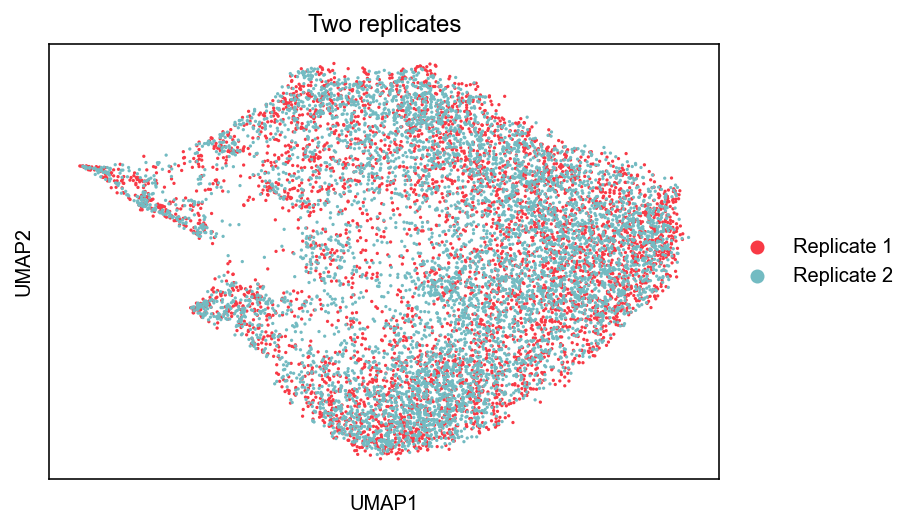

In [ ]:
sc.pl.umap(ad_epi, color="Rep", title="Two replicates")

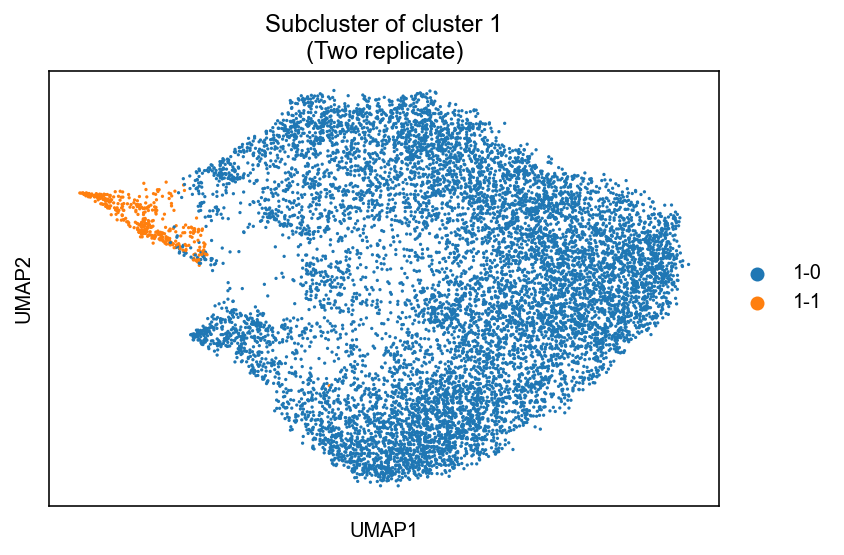

In [ ]:
sc.pl.umap(ad_epi, color="leiden", title="Subcluster of cluster 1\n(Two replicate)")

In [ ]:
# ad_epi.obs["leiden"] = np.where(ad_epi.obs["leiden"] == "1", "0", ad_epi.obs["leiden"])
# ad_epi.obs["leiden"] = np.where(ad_epi.obs["leiden"] == "2", "1", ad_epi.obs["leiden"])

In [ ]:
ad_epi.obs["leiden"] = "1-" + ad_epi.obs["leiden"].astype("str")

... storing 'leiden' as categorical


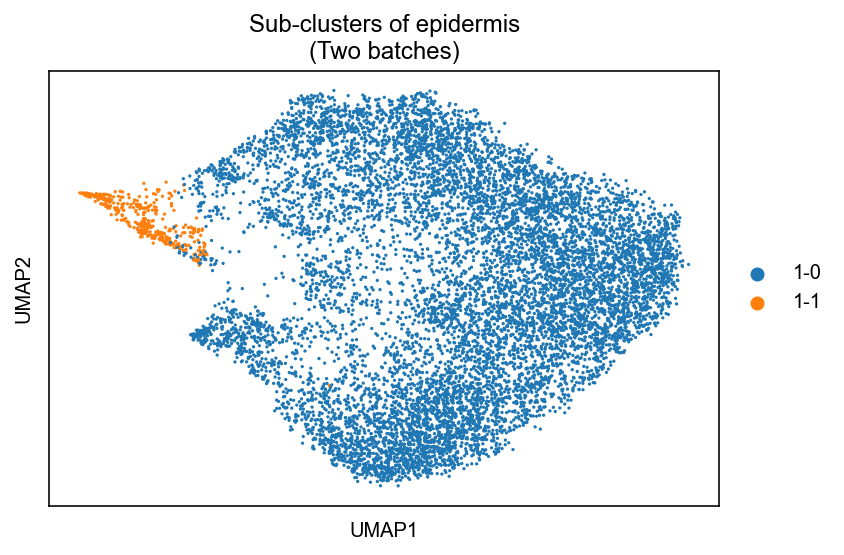

In [ ]:
sc.pl.umap(ad_epi, color="leiden", title="Sub-clusters of epidermis\n(Two batches)")

In [ ]:
# toPkl(ad_epi, 'ad_epi_20230214_twoReps', 'ipf')

In [ ]:
# ad_epi = loadPkl('ad_epi_20230214_twoReps', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')

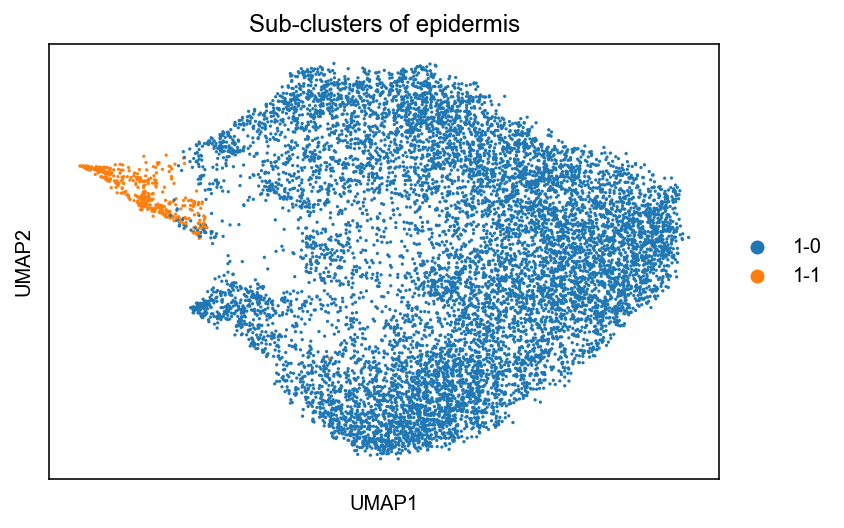

In [ ]:
sc.pl.umap(ad_epi, color="leiden", title="Sub-clusters of epidermis")

In [ ]:
ad.obs = ad.obs.assign(
    subcluster_of_1=lambda x: np.where(
        x.index.isin(ad_epi.obs.index),
        ad_epi.obs["leiden"].reindex(x.index),
        x["leiden"],
    ),
    subcluster_of_1_rep1_only=ad_rep1.obs.rename(
        index=lambda x: x + "-Batch 1"
    ).reindex(ad.obs.index)["leiden_subEpi"],
)

In [ ]:
_ls = ["1-0", "1-1"]
df_subclusterOfEpi = ad.obs.query(
    "Batch == 'Batch 1' & (subcluster_of_1.isin(@_ls) | subcluster_of_1_rep1_only.isin(@_ls))"
)

In [ ]:
df_subclusterOfEpi = df_subclusterOfEpi.assign(
    subcluster_of_1_rep1_only=lambda x: x["subcluster_of_1_rep1_only"].map(
        lambda x: "Non-cluster1" if not x.startswith("1-") else x
    ),
    subcluster_of_1=lambda x: x["subcluster_of_1"].map(
        lambda x: "Non-cluster1" if not x.startswith("1-") else x
    ),
)

In [ ]:
ad

AnnData object with n_obs × n_vars = 55683 × 32007
    obs: 'batch_time', 'n_counts', 'ct_merged', 'Sample_4', 'Batch', 'Batch_Sample', '_scvi_batch', '_scvi_labels', 'leiden', 'Rep', 'new_epi_subcluster', 'subcluster_of_1', 'subcluster_of_1_rep1_only'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', '_scvi_manager_uuid', '_scvi_uuid', 'ct_merged_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Rep_colors'
    obsm: 'X_pca_normalizeLog', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', 'scDblFinder'
    layers: 'normalize_log', 'raw'
    obsp: 'connectivities', 'distances'

In [ ]:
{
    **singleCellTools.basic.getadataColor(ad_rep1, "leiden_subEpi"),
    "Non-cluster1": "#FFFFFF",
}

{'1-0': '#1f77b4',
 '1-1': '#ff7f0e',
 '2': '#2ca02c',
 '3': '#d62728',
 '4': '#9467bd',
 '5': '#8c564b',
 '6': '#e377c2',
 '7': '#7f7f7f',
 '8': '#bcbd22',
 '9': '#17becf',
 'Non-cluster1': '#FFFFFF'}

2023-06-20 15:41:13 - WARNING -  The following arguments are deprecated and should be removed: figSize in sankey()


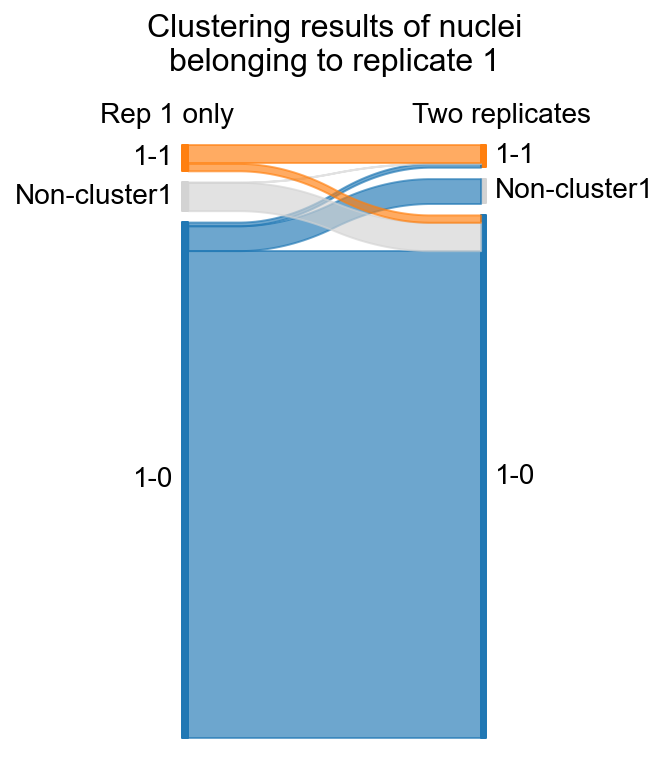

In [ ]:
with plt.rc_context({"font.family": "Arial"}):
    ax = pysankey.sankey(
        df_subclusterOfEpi["subcluster_of_1_rep1_only"],
        df_subclusterOfEpi["subcluster_of_1"],
        figSize=(3, 6),
        colorDict={
            **singleCellTools.basic.getadataColor(ad_rep1, "leiden_subEpi"),
            "Non-cluster1": "#D3D3D3",
        },
    )
    ax.text(
        1,
        0.98,
        "Two replicates",
        ha="center",
        va="bottom",
        fontsize=14,
        transform=ax.transAxes,
    )

    ax.text(
        0,
        0.98,
        "Rep 1 only",
        ha="center",
        va="bottom",
        fontsize=14,
        transform=ax.transAxes,
    )
    ax.set_title(
        "Clustering results of nuclei\nbelonging to replicate 1", y=1.05, fontsize=16
    )

Text(0, 0.5, 'Subclusters')

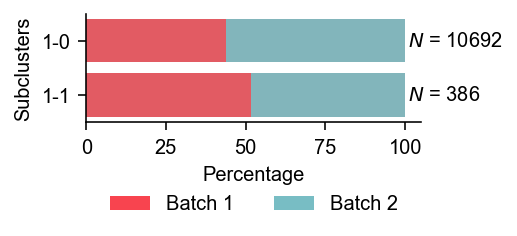

In [ ]:
fig, ax = plt.subplots(figsize=(3, 1))
singleCellTools.plotting.plotLabelPercentageInCluster(
    ad_epi,
    "leiden",
    "Batch",
    swapAxes=True,
    dt_kwargsForLegend=dict(loc="upper center", bbox_to_anchor=(0.5, -0.5), ncol=2),
)
plt.ylabel("Subclusters")

In [ ]:
ad_epi.obs["Batch"] = ad_epi.obs["Batch"].cat.set_categories(["Batch 1", "Batch 2"])

Text(0.5, 0, 'Subclusters')

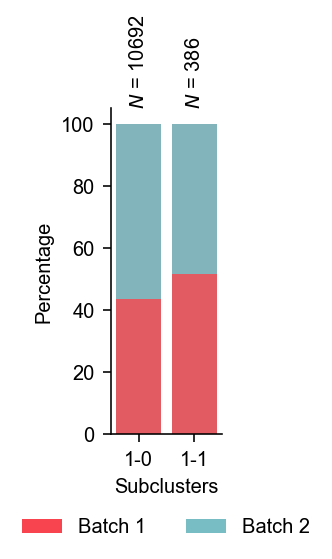

In [ ]:
fig, ax = plt.subplots(figsize=(1, 3))
singleCellTools.plotting.plotLabelPercentageInCluster(
    ad_epi[ad_epi.obs.sort_values("Batch").index].copy(),
    "leiden",
    "Batch",
    dt_kwargsForLegend=dict(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2),
)
plt.xlabel("Subclusters")

In [ ]:
dt_epiMarkerGene = (
    ad_rep1.uns["leiden_subEpi_cellexES"]
    .query(
        "enrichScore > 0.8 & leiden_subEpi.str.startswith('1-') & gene in @ls_snfGenes",
        engine="python",
    )
    .groupby("leiden_subEpi")["gene"]
    .agg(list)
    .to_dict()
)

In [ ]:
ad.obs["new_epi_subcluster"] = ad.obs["leiden"].astype(str)

In [ ]:
ad.obs.loc[ad_epi.obs.index, "new_epi_subcluster"] = ad_epi.obs["leiden"].astype(str)

In [ ]:
ad.obs["new_epi_subcluster"] = (
    ad.obs["new_epi_subcluster"].astype(str).str.split(" ").str[0]
)

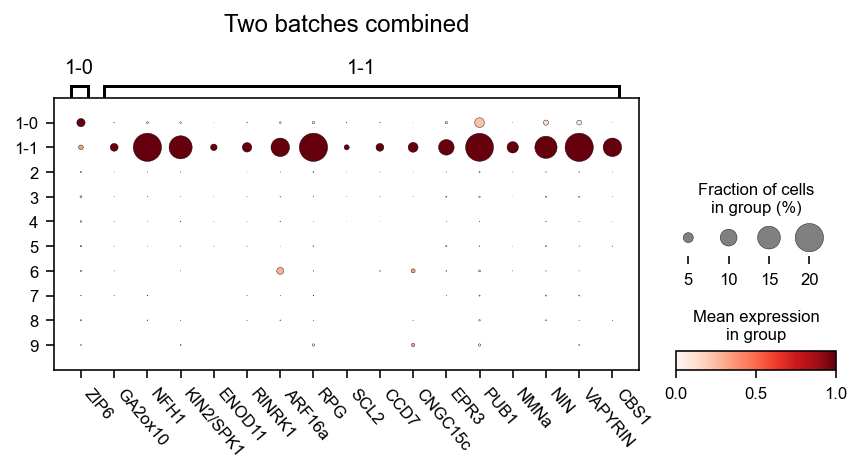

In [ ]:
axs = sc.pl.dotplot(
    ad,
    dt_epiMarkerGene,
    "subcluster_of_1",
    layer="normalize_log",
    standard_scale="var",
    dot_max=0.2,
    show=False,
    figsize=(7, 2.5),
)
ax = axs["mainplot_ax"]
plt.sca(ax)
ls_xGeneName = (
    ax.get_xticklabels() | F(map, lambda x: dt_locus2name[x.get_text()]) | F(list)
)
plt.xticks(
    range(len(ls_xGeneName)) | F(map, lambda x: x + 0.5) | F(list),
    ls_xGeneName,
    rotation=-50,
    ha="left",
)
# plt.title("Known sub-cluster-specific-SNF genes\n(Batch 1)", y=1.2)
plt.title("Two batches combined", y=1.2)
# axs['size_legend_ax'].set_position([0.25, -0.3, 0.15, 0.1])
# axs['color_legend_ax'].set_position([0.45, -0.3, 0.15, 0.05])
plt.show()

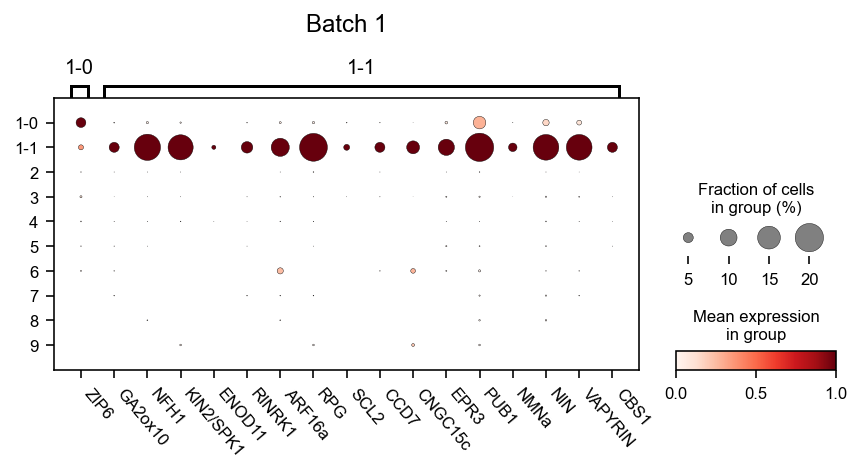

In [ ]:
axs = sc.pl.dotplot(
    ad[ad.obs.eval("Batch == 'Batch 1'")],
    dt_epiMarkerGene,
    "subcluster_of_1",
    layer="normalize_log",
    standard_scale="var",
    dot_max=0.2,
    show=False,
    figsize=(7, 2.5),
)
ax = axs["mainplot_ax"]
plt.sca(ax)
ls_xGeneName = (
    ax.get_xticklabels() | F(map, lambda x: dt_locus2name[x.get_text()]) | F(list)
)
plt.xticks(
    range(len(ls_xGeneName)) | F(map, lambda x: x + 0.5) | F(list),
    ls_xGeneName,
    rotation=-50,
    ha="left",
)
# plt.title("Known sub-cluster-specific-SNF genes\n(Batch 1)", y=1.2)
plt.title("Batch 1", y=1.2)
# axs['size_legend_ax'].set_position([0.25, -0.3, 0.15, 0.1])
# axs['color_legend_ax'].set_position([0.45, -0.3, 0.15, 0.05])
plt.show()

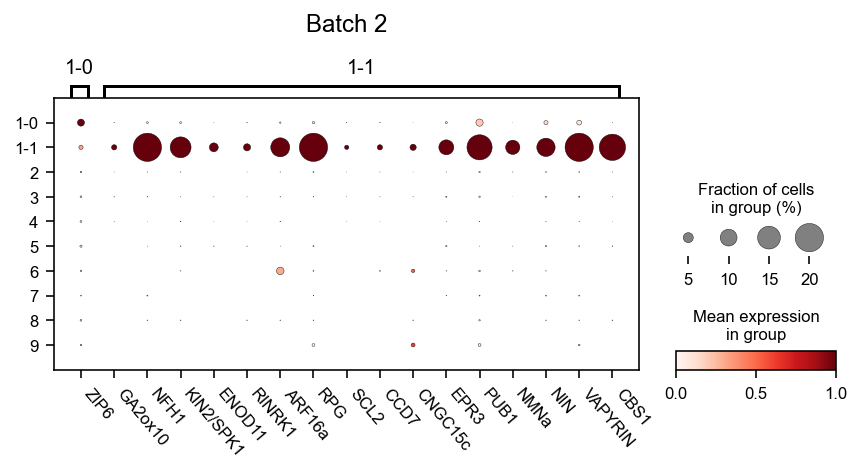

In [ ]:
axs = sc.pl.dotplot(
    ad[ad.obs.eval("Batch == 'Batch 2'")],
    dt_epiMarkerGene,
    "subcluster_of_1",
    layer="normalize_log",
    standard_scale="var",
    dot_max=0.2,
    show=False,
    figsize=(7, 2.5),
)
ax = axs["mainplot_ax"]
plt.sca(ax)
ls_xGeneName = (
    ax.get_xticklabels() | F(map, lambda x: dt_locus2name[x.get_text()]) | F(list)
)
plt.xticks(
    range(len(ls_xGeneName)) | F(map, lambda x: x + 0.5) | F(list),
    ls_xGeneName,
    rotation=-50,
    ha="left",
)
# plt.title("Known sub-cluster-specific-SNF genes\n(Batch 1)", y=1.2)
plt.title("Batch 2", y=1.2)
# axs['size_legend_ax'].set_position([0.25, -0.3, 0.15, 0.1])
# axs['color_legend_ax'].set_position([0.45, -0.3, 0.15, 0.05])
plt.show()

In [ ]:
# toPkl(ad_epi, "ad_epi_0621", "ipf")

2023-06-21 14:23:55.181 | INFO     | jpy_tools.otherTools:toPkl:476 - please run `loadPkl('ad_epi_0621', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


In [ ]:
# toPkl(ad_epi, "ad_epi_20230629_two_rep_integrate", "ipf", dir_path=dir_result)

2023-06-29 11:54:21.179 | INFO     | jpy_tools.otherTools:toPkl:476 - please run `loadPkl('ad_epi_20230629_two_rep_integrate', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


## WGCNA

In [ ]:
import triku as tk

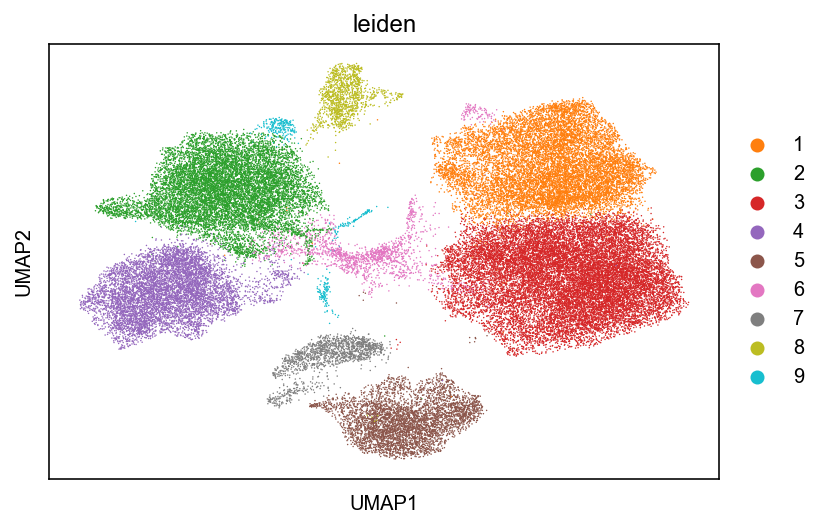

In [ ]:
sc.pl.umap(ad, color="leiden")

In [ ]:
nGenes = 6000
ls_cluster = ["1", "3"]
ls_sample = ["0.5 hpi"]
metaSplit = True
fcName = "sft"
dt_strToPickFc = {
    "sft": lambda x: x["SFT.R.sq"] >= 0.8,
    "k": lambda x: ((x["SFT.R.sq"] >= 0.8) & (x["mean.k."] <= 100)),
}
fc_autoPickSoftPower = dt_strToPickFc[fcName]

In [ ]:
ad_wgcna = ad[ad.obs.eval("leiden in @ls_cluster & Sample_4 in @ls_sample")].copy()

In [ ]:
ad_wgcna.obs["temp"] = "a"
ad_wgcna.X = ad_wgcna.layers["raw"].copy()
sc.pp.filter_genes(ad_wgcna, min_cells=5)
sc.pp.pca(ad_wgcna)
sc.pp.neighbors(ad_wgcna)

In [ ]:
tk.tl.triku(ad_wgcna, n_features=10000)

WARNING | 2023-06-20 16:45:32,720 - triku.logg - The count matrix contains more than 25000 genes. We recommend filtering some genes, up to 15000 - 18000 genes. You can do that in scanpy with the function 'sc.pp.filter_genes()'.

2023-06-20 16:45:32 - WARNING - The count matrix contains more than 25000 genes. We recommend filtering some genes, up to 15000 - 18000 genes. You can do that in scanpy with the function 'sc.pp.filter_genes()'.


In [ ]:
ls_hvg = (
    ad_wgcna.var["triku_distance_uncorrected"]
    .rank(ascending=False)
    .loc[lambda x: x <= 6000]
    .index.to_list()
)

In [ ]:
ad_wgcna.var["triku_distance_uncorrected"].rank(ascending=False).loc[
    ["MTR_7g073660", "MTR_5g086130", "MTR_5g083030"]
]

MTR_7g073660    3727.0
MTR_5g086130    2921.0
MTR_5g083030     443.0
Name: triku_distance_uncorrected, dtype: float64

In [ ]:
ad_wgcna.layers["raw"] = ad_wgcna.layers["raw"].copy()

In [ ]:
ad_wgcna = ad_wgcna.copy()

In [ ]:
import scipy.sparse as ss

In [ ]:
ad_wgcna.layers["raw"] = ss.csc_array(ad_wgcna.layers["raw"])

2023-06-20 16:47:16.873 | INFO     | jpy_tools.singleCellTools.geneEnrichInfo:_getMetaCells:1283 - ('1', '0.5 hpi', 'Batch 1') info:: 1515 cells, 2330809.0 UMIs
set unnamed.var[rare_gene]: 0 true (0%) out of 20681 bools
2023-06-20 16:47:17 - INFO - set unnamed.var[rare_gene]: 0 true (0%) out of 20681 bools
set unnamed.var[rare_gene_module]: 20681 int32 elements with all outliers (100%)
2023-06-20 16:47:17 - INFO - set unnamed.var[rare_gene_module]: 20681 int32 elements with all outliers (100%)
set unnamed.obs[cells_rare_gene_module]: 1515 int32 elements with all outliers (100%)
2023-06-20 16:47:17 - INFO - set unnamed.obs[cells_rare_gene_module]: 1515 int32 elements with all outliers (100%)
set unnamed.obs[rare_cell]: 0 true (0%) out of 1515 bools
2023-06-20 16:47:17 - INFO - set unnamed.obs[rare_cell]: 0 true (0%) out of 1515 bools
set unnamed.layers[downsampled]: csr_matrix 1515 X 20681 float32s (891156 > 0)
2023-06-20 16:47:17 - INFO - set unnamed.layers[downsampled]: csr_matrix 151

leiden  Sample_4  Batch  
3       0.5 hpi   Batch 1    80
                  Batch 2    55
1       0.5 hpi   Batch 1    45
                  Batch 2    25
dtype: int64
These [] groups are skipped or changed due to small size


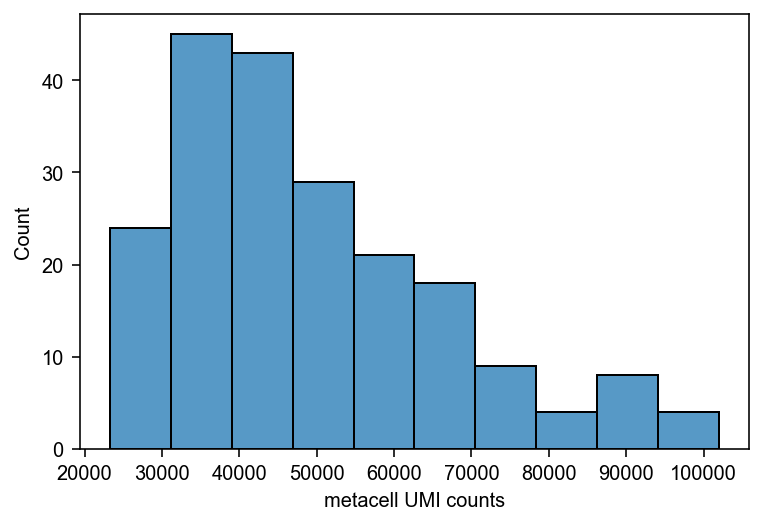

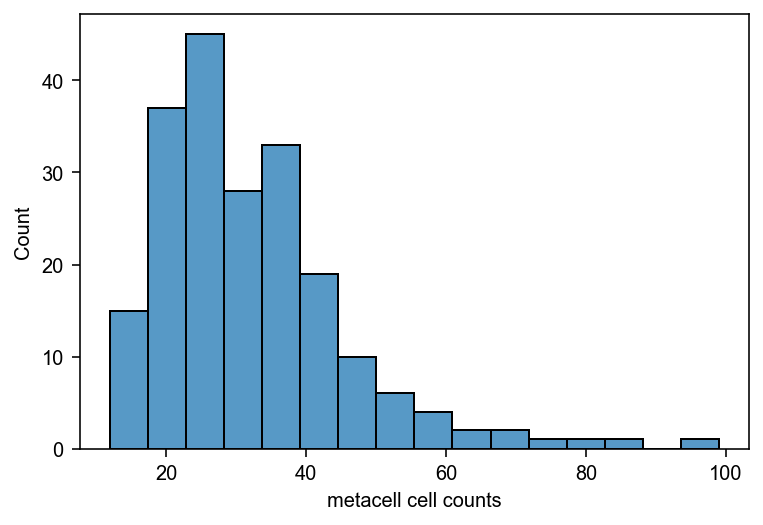

pickSoftThreshold: will use block size 6000.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 6000 of 6000
   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k. max.k.
1      1  0.01290  4.79          0.987 3040.000  3030.000 3220.0
2      2  0.00338  1.40          0.937 1580.000  1570.000 1790.0
3      3  0.08870 -3.87          0.853  850.000   840.000 1060.0
4      4  0.57600 -6.08          0.958  469.000   457.000  689.0
5      5  0.77400 -5.32          0.990  266.000   254.000  474.0
6      6  0.83800 -4.29          0.989  155.000   144.000  341.0
7      7  0.85800 -3.66          0.978   92.400    83.100  254.0
8      8  0.87600 -3.22          0.978   56.800    48.800  195.0
9      9  0.87100 -2.96          0.958   35.800    29.100  154.0
10    10  0.89200 -2.71          0.967   23.100    17.500  123.0
11    12  0.90800 -2.42          0.965   10.400     6.610   82.9
12    14  0.92800 -2.22          0.967    5.090     2.620   59.8


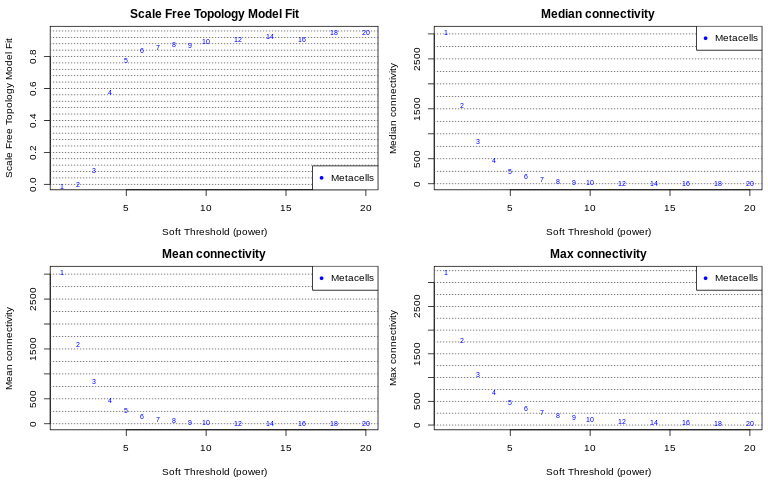

2023-06-20 16:47:57.567 | INFO     | jpy_tools.singleCellTools.geneEnrichInfo:scWGCNA:1517 - Soft Power: 6


 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


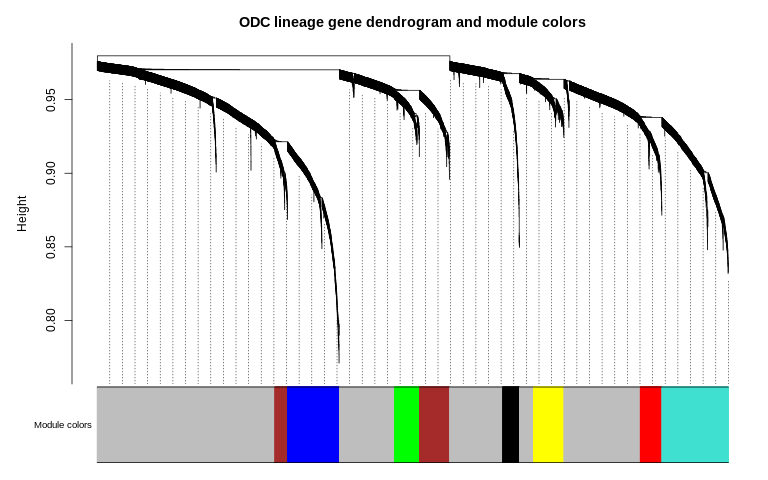

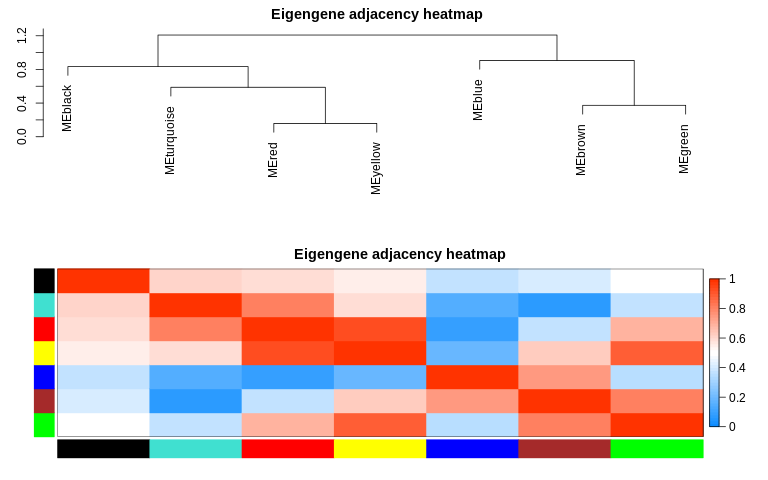

Loading objects:
  consTomDS


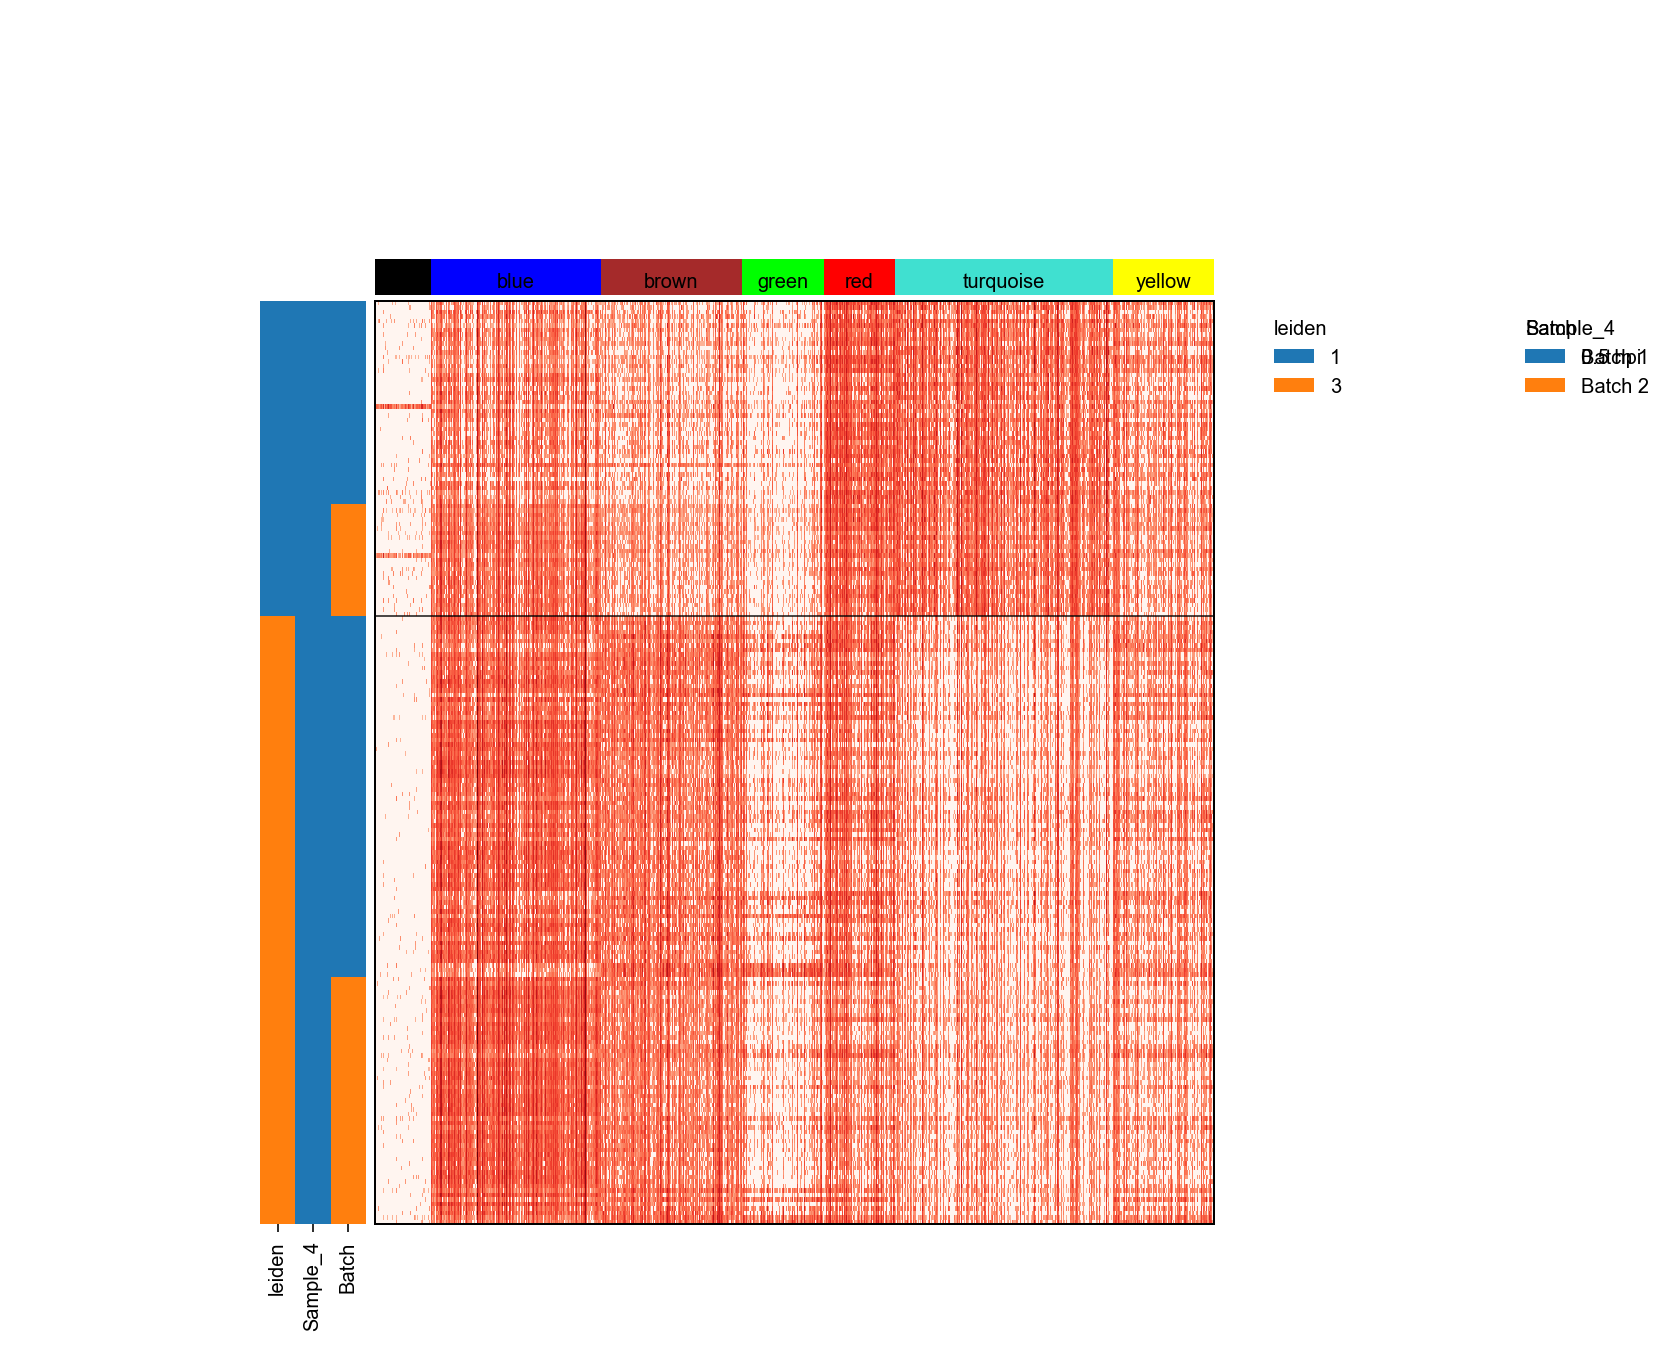

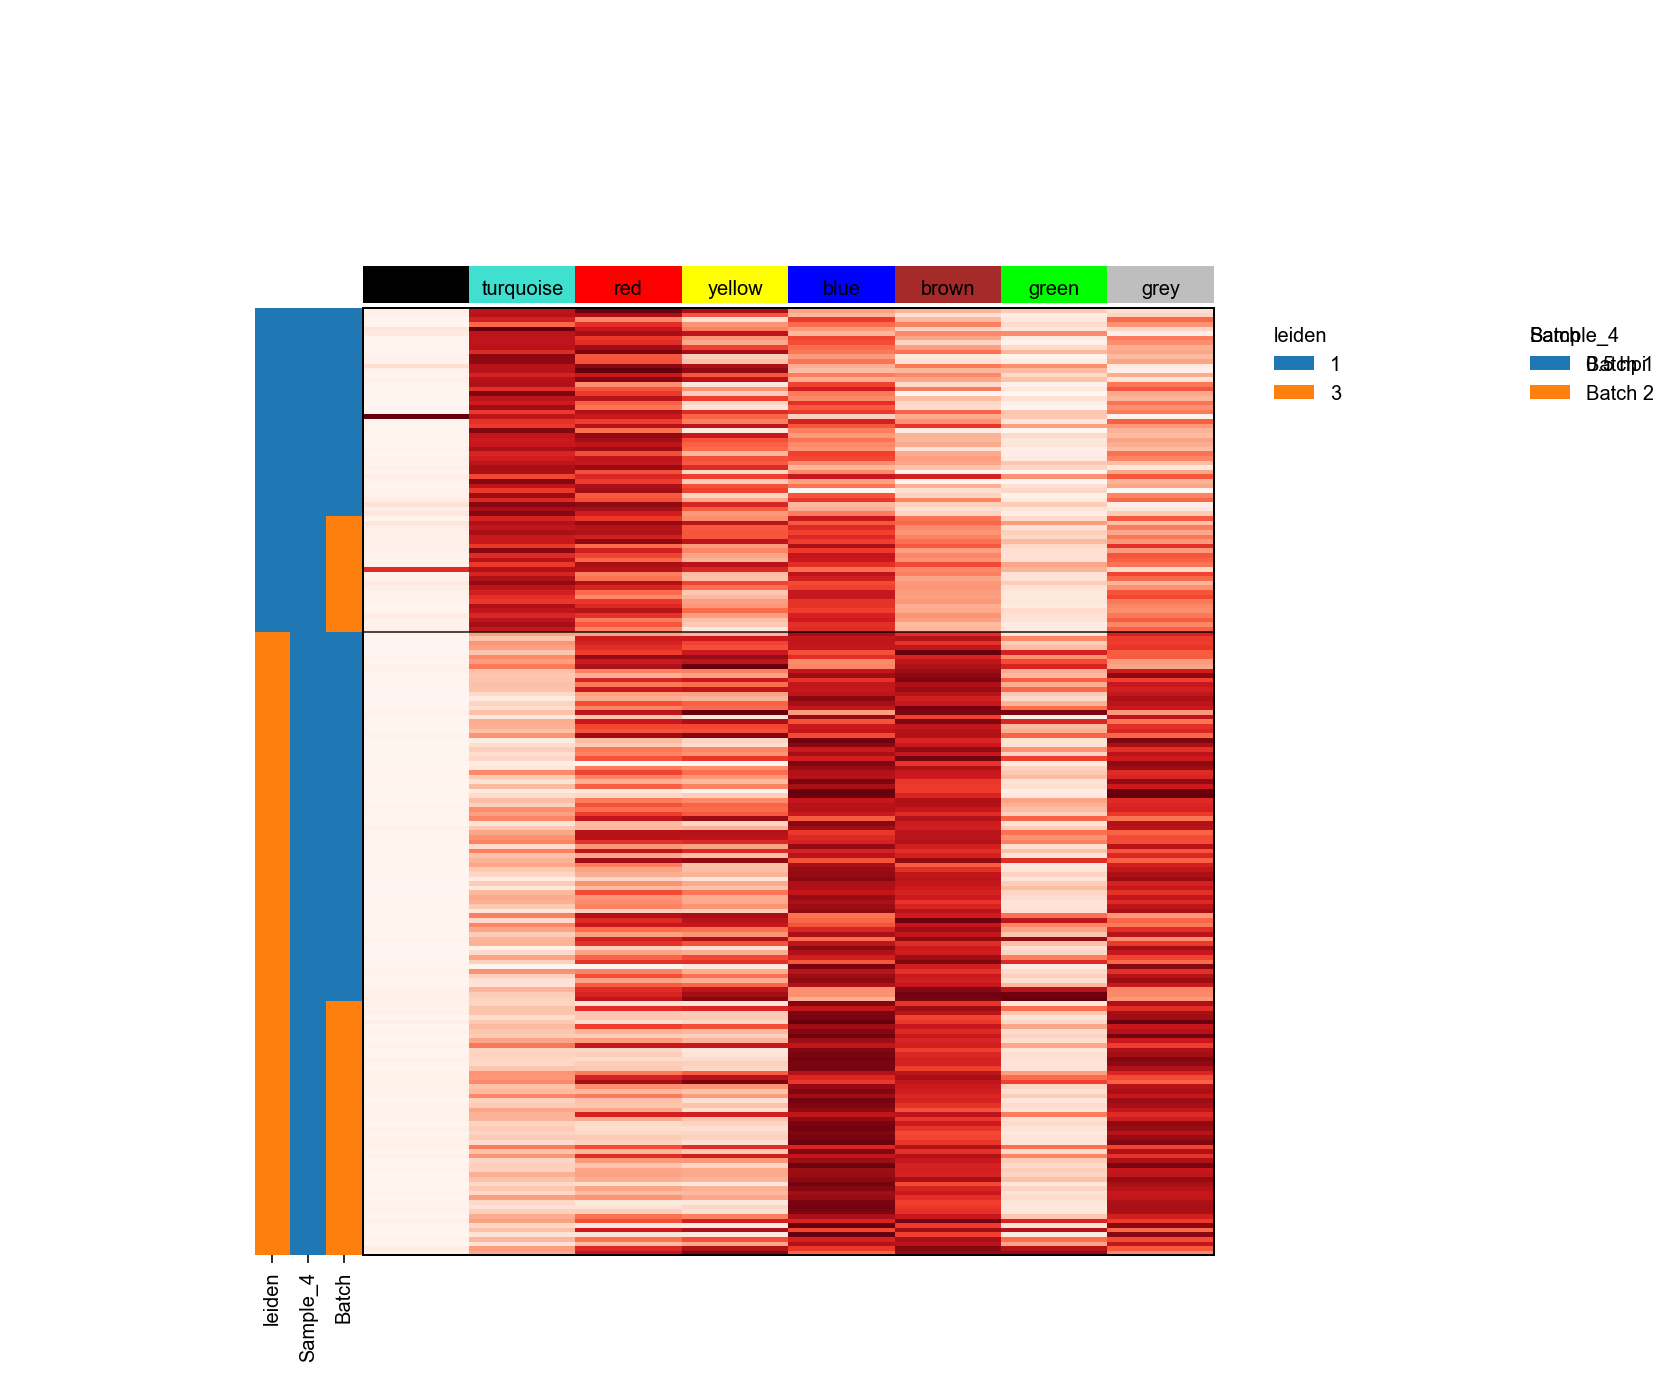

Create regulons from a dataframe of enriched features.
Additional columns saved: []


100%|██████████| 1/1 [00:37<00:00, 37.42s/it]
... storing 'temp' as categorical


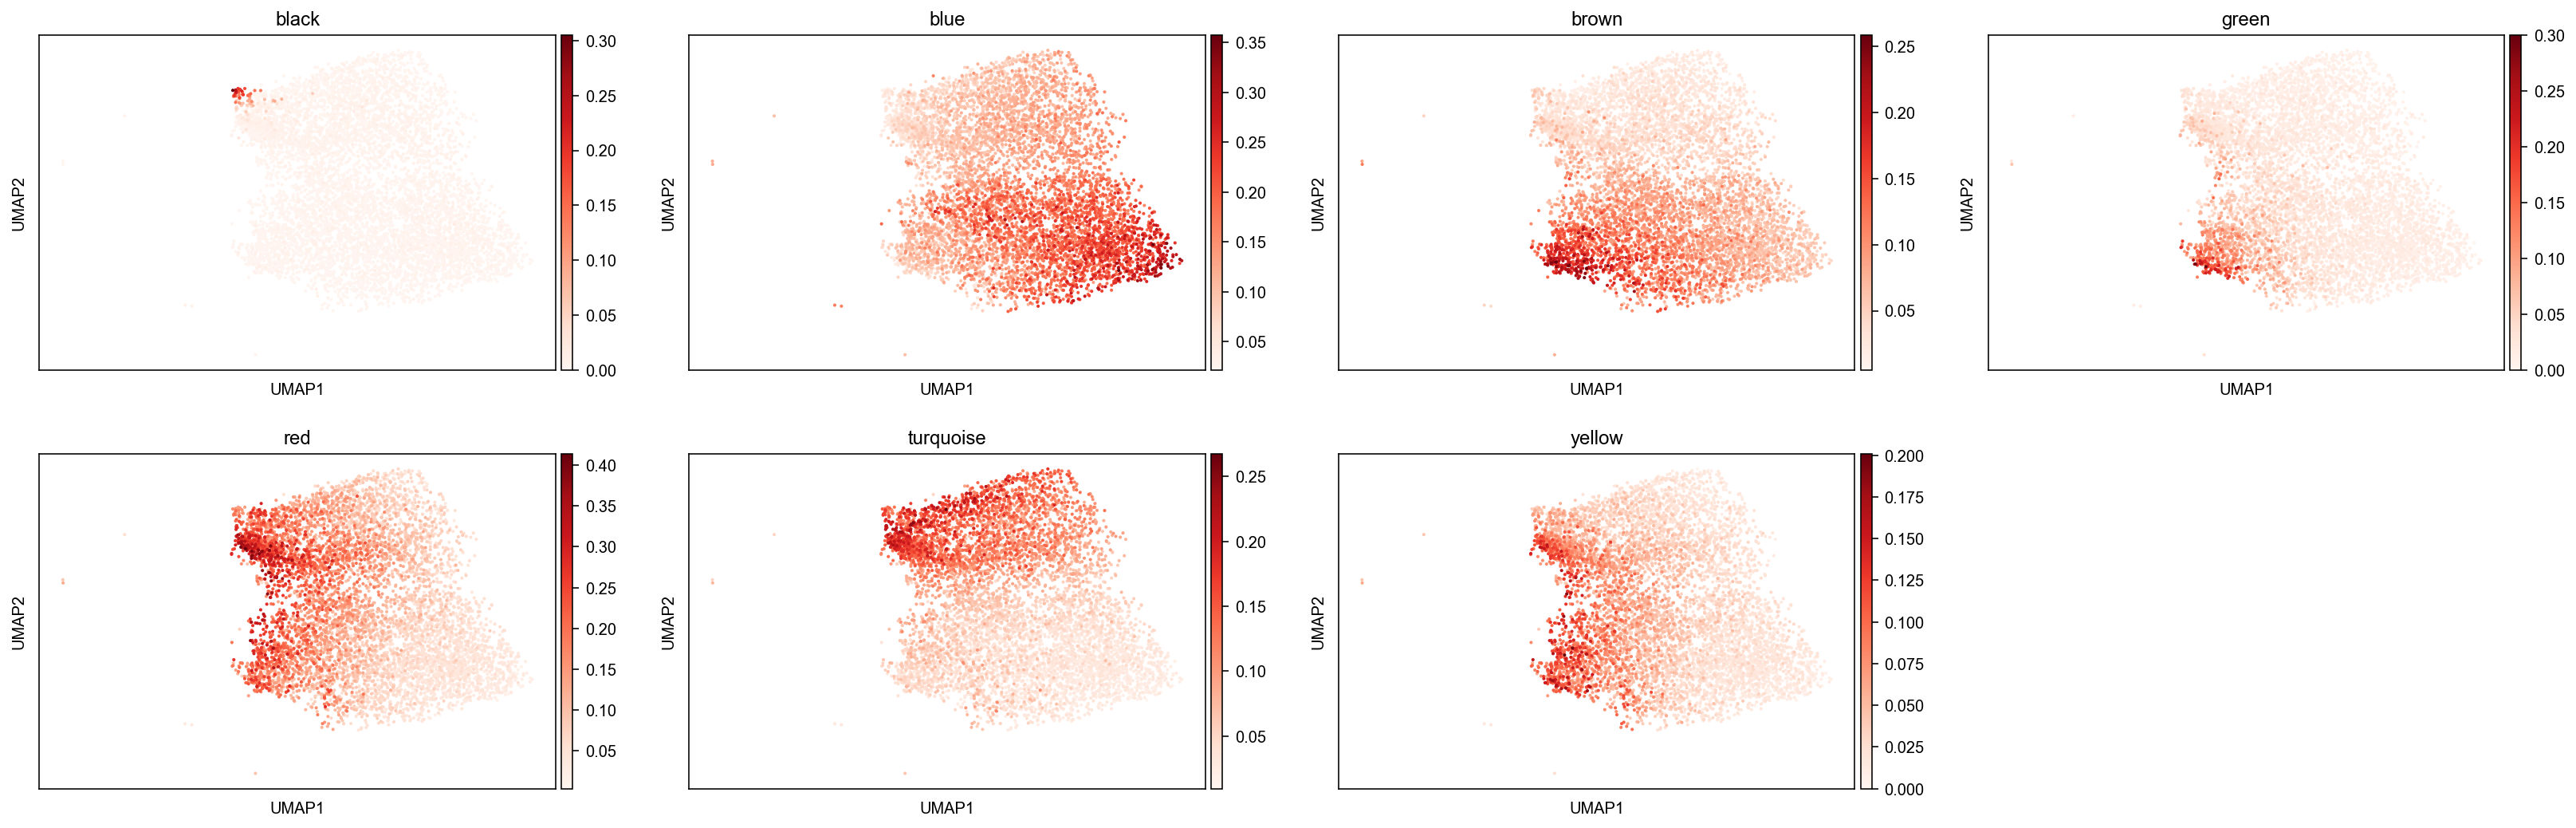

In [ ]:
ad_MetaWgcna = singleCellTools.geneEnrichInfo.scWGCNA(
    ad_wgcna,
    "raw",
    ["leiden", "Sample_4", "Batch"],
    False,
    target_metacell_size=5e4,
    dir_result=f"{dir_result}/wgcna/",
    jobid="ad_epiCor_M0.5_rep3rep1Merged_wgcna_20230620",
    ls_hvgGene=ls_hvg,
    mergeCutHeight=0.15,
    softPower="auto",
    fc_autoPickSoftPower=fc_autoPickSoftPower,
    calcAucell=True,
)

In [ ]:
# toPkl(ad_MetaWgcna, "ad_MetaWgcna_epi_0621", "ipf")

2023-06-21 14:24:18.670 | INFO     | jpy_tools.otherTools:toPkl:476 - please run `loadPkl('ad_MetaWgcna_epi_0621', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


In [ ]:
_ad = singleCellTools.plotting.obsmToObs(
    ad_wgcna, "ad_epiCor_M0.5_rep3rep1Merged_wgcna_20230620_AUCell"
)

... storing 'temp' as categorical


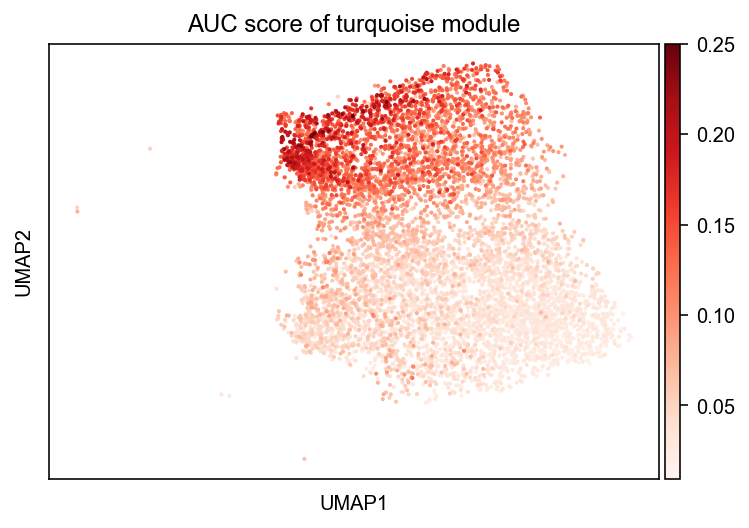

In [ ]:
sc.pl.umap(
    _ad,
    color="turquoise",
    cmap="Reds",
    vmax=0.25,
    title="AUC score of turquoise module",
)

In [ ]:
_ad

AnnData object with n_obs × n_vars = 7119 × 20681
    obs: 'Batch', 'Batch_Sample', 'Rep', 'Sample_4', '_scvi_batch', '_scvi_labels', 'batch_time', 'black', 'blue', 'brown', 'ct_merged', 'green', 'leiden', 'n_counts', 'new_epi_subcluster', 'red', 'subcluster_of_1', 'subcluster_of_1_rep1_only', 'temp', 'turquoise', 'yellow'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'Batch_colors', '_scvi_manager_uuid', '_scvi_uuid', 'ct_merged_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Rep_colors', 'leiden_cellexES', 'pca', 'triku_params', 'plot_obsm'
    obsm: 'X_pca_normalizeLog', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', 'scDblFinder', 'X_pca', 'ad_epiCor_M0.5_rep3rep1Merged_wgcna_20230620_AUCell'

In [ ]:
grDevices = importr("grDevices")


def rgb_to_hex(r, g, b):
    return ("#{:02X}{:02X}{:02X}").format(r, g, b)


name2hex = lambda x: rgb_to_hex(*grDevices.col2rgb(x))
ls_moduleAllGenes = (
    ad_MetaWgcna.varm["KME"]
    .query("module != 'grey'")
    .sort_values("module")
    .index.to_list()
)

In [ ]:
import adjustText

141


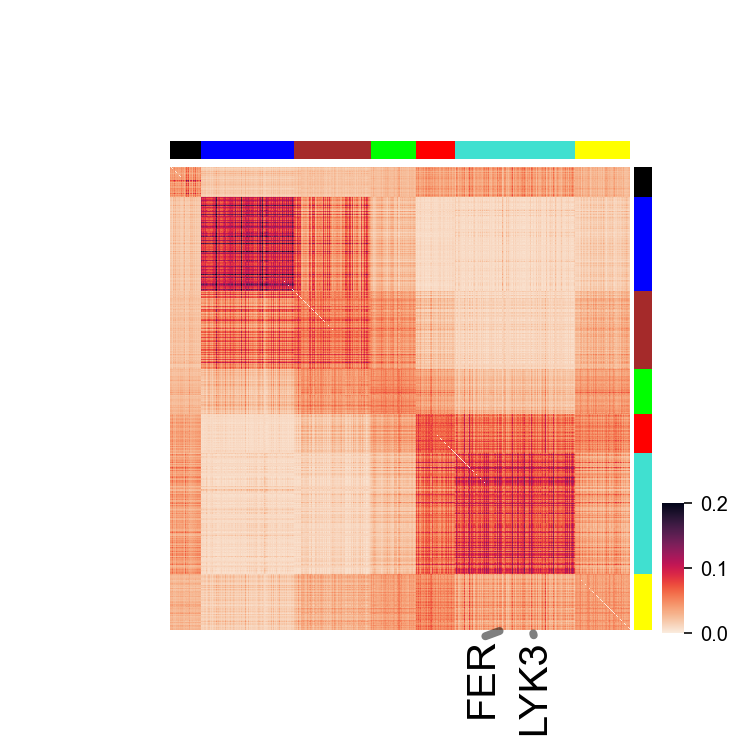

In [ ]:
axs = sns.clustermap(
    ad_MetaWgcna[:, ls_moduleAllGenes].varp["TOM"],
    cmap="rocket_r",
    vmax=0.2,
    row_colors=ad_MetaWgcna[:, ls_moduleAllGenes]
    .varm["KME"]["module"]
    .map(name2hex)
    .to_numpy(),
    col_colors=ad_MetaWgcna[:, ls_moduleAllGenes]
    .varm["KME"]["module"]
    .map(name2hex)
    .to_numpy(),
    col_cluster=False,
    row_cluster=False,
    cbar_pos=(0.93, 0.11, 0.03, 0.18),
    # dendrogram_ratio=0,
    figsize=(5, 5),
)
plt.sca(axs.ax_heatmap)
plt.xticks([])
plt.yticks([])

pos_axRowColor = axs.ax_row_colors.get_position()
pos_axHeatmap = axs.ax_heatmap.get_position()
axs.ax_row_colors.set_position(
    [
        pos_axHeatmap.x1 + 0.005,
        pos_axRowColor.y0,
        pos_axRowColor.x1 - pos_axRowColor.x0,
        pos_axRowColor.y1 - pos_axRowColor.y0,
    ]
)

ax = axs.ax_heatmap.figure.add_axes([0, 1, 1, 1])
plt.sca(ax)
pos_axHeatmap = axs.ax_heatmap.get_position()
ax.set_position(
    [
        pos_axHeatmap.x0,
        pos_axHeatmap.y0 - 0.15,
        pos_axHeatmap.x1 - pos_axHeatmap.x0,
        0.15,
    ]
)
plt.xlim(axs.ax_heatmap.get_xlim())
plt.ylim((0, 100))
ls_text = []
for pos, name in zip(
    (
        ls_moduleAllGenes.index("MTR_7g073660"),
        ls_moduleAllGenes.index("MTR_5g086130"),
    ),
    ["LYK3", "FER"],
):
    text = plt.text(
        pos, 100, name, ha="center", va="top", rotation=90, fontdict=dict(size=20)
    )
    ls_text.append(text)

x = adjustText.adjust_text(
    ls_text,
    x=np.array(
        np.meshgrid(
            np.linspace(*axs.ax_heatmap.get_xlim(), 1000), np.linspace(90, 100, 30)
        )
    ).T.reshape(-1, 2)[:, 0],
    y=np.array(
        np.meshgrid(
            np.linspace(*axs.ax_heatmap.get_xlim(), 1000), np.linspace(90, 100, 30)
        )
    ).T.reshape(-1, 2)[:, 1],
    lim=1000,
    force_text=(0.1, 0),
    force_points=(0, 0.002),
    expand_text=(1.4, 1),
    arrowprops=dict(arrowstyle="-", color="black", alpha=0.5, lw=4),
    ha="center",
    va="top",
    precision=0.0001,
    arrow_bbox_pos=(0.5, 1),
)
plt.axis("off")
print(x)

plt.show()

In [ ]:
ad_MetaWgcna[:, ["MTR_7g073660", "MTR_5g086130", "MTR_5g083030"]].varm["KME"] # The three genes still located in the same module

GeneSymbol Initially.Assigned.Module.Color  kMEblack  \
MTR_7g073660  MTR_7g073660                       turquoise  0.140957   
MTR_5g086130  MTR_5g086130                       turquoise -0.105403   
MTR_5g083030  MTR_5g083030                       turquoise  0.243931   

              kMEturquoise    kMEred  kMEyellow   kMEblue  kMEbrown  kMEgreen  \
MTR_7g073660      0.441111  0.340429   0.034216 -0.341293 -0.443654 -0.187665   
MTR_5g086130      0.507727  0.272888   0.027912 -0.390296 -0.460464 -0.150971   
MTR_5g083030      0.702290  0.521022   0.173551 -0.625228 -0.655430 -0.211263   

               kMEgrey       kME     module  
MTR_7g073660 -0.418733  0.441111  turquoise  
MTR_5g086130 -0.447262  0.507727  turquoise  
MTR_5g083030 -0.702166  0.702290  turquoise